## Read Config and Start

In [1]:
import sys

def info(type, value, tb):
    if hasattr(sys, 'ps1') or not sys.stderr.isatty():
    # we are in interactive mode or we don't have a tty-like
    # device, so we call the default hook
        sys.__excepthook__(type, value, tb)
    else:
        import traceback, pdb
        # we are NOT in interactive mode, print the exception...
        traceback.print_exception(type, value, tb)
        print
        # ...then start the debugger in post-mortem mode.
        # pdb.pm() # deprecated
        pdb.post_mortem(tb) # more "modern"

sys.excepthook = info

import logging
import os
import warnings
warnings.filterwarnings("ignore")

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
from typing import List

import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf, ListConfig
import torch
import run_seed_fn
from helpers.utils import create_obs_config
import lightning as L

from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="conf/"):
    cfg = compose(config_name='config.yaml')
    method_cfg = compose(config_name='method/ManiGaussian_BC.yaml')
    cfg.method = method_cfg.method
    # print(cfg.method)
    print(OmegaConf.to_yaml(cfg))
    cfg_yaml = OmegaConf.to_yaml(cfg)

method:
  name: ManiGaussian_BC
  use_fabric: true
  use_depth: true
  use_neural_rendering: true
  num_view_for_nerf: 20
  language_model: CLIP
  language_model_dim: 512
  image_crop_size: 64
  bounds_offset:
  - 0.15
  voxel_sizes:
  - 100
  include_prev_layer: false
  num_latents: 2048
  latent_dim: 512
  transformer_depth: 6
  transformer_iterations: 1
  cross_heads: 1
  cross_dim_head: 64
  latent_heads: 8
  latent_dim_head: 64
  pos_encoding_with_lang: true
  conv_downsample: true
  lang_fusion_type: seq
  voxel_patch_size: 5
  voxel_patch_stride: 5
  final_dim: 128
  input_dropout: 0.1
  attn_dropout: 0.1
  decoder_dropout: 0.0
  lr: 0.0005
  lr_scheduler: false
  num_warmup_steps: 3000
  optimizer: lamb
  lambda_weight_l2: 1.0e-06
  trans_loss_weight: 1.0
  rot_loss_weight: 1.0
  grip_loss_weight: 1.0
  collision_loss_weight: 1.0
  rotation_resolution: 5
  activation: lrelu
  norm: None
  crop_augmentation: true
  transform_augmentation:
    apply_se3: true
    aug_xyz:
    - 0

In [2]:
cfg.rlbench.demo_path = 'data/train_data'
cfg.rlbench.tasks = ['close_jar']
cfg.method.use_fabric = False
cfg.framework.use_wandb = False
cfg.method.use_wandb = False
cfg.method.neural_renderer.use_dynamic_field = True
cfg.method.neural_renderer.foundation_model_name = 'diffusion'
# cfg.method.neural_renderer.visdom = True

In [3]:

os.environ['MASTER_ADDR'] = cfg.ddp.master_addr
os.environ['MASTER_PORT'] = str(cfg.ddp.master_port)
os.environ['OPENBLAS_NUM_THREADS'] = '1'
print("device available: ", torch.cuda.device_count())

cfg.rlbench.cameras = cfg.rlbench.cameras \
    if isinstance(cfg.rlbench.cameras, ListConfig) else [cfg.rlbench.cameras]
obs_config = create_obs_config(cfg.rlbench.cameras,
                                cfg.rlbench.camera_resolution,
                                cfg.method.name,
                                use_depth=cfg.method.use_depth,
                                )
multi_task = len(cfg.rlbench.tasks) > 1

cwd = os.getcwd()
logging.info('CWD:' + os.getcwd())

if cfg.framework.start_seed >= 0:
    # seed specified
    start_seed = cfg.framework.start_seed
elif cfg.framework.start_seed == -1 and \
        len(list(filter(lambda x: 'seed' in x, os.listdir(cwd)))) > 0:
    # unspecified seed; use largest existing seed plus one
    largest_seed =  max([int(n.replace('seed', ''))
                            for n in list(filter(lambda x: 'seed' in x, os.listdir(cwd)))])
    start_seed = largest_seed + 1
else:
    # start with seed 0
    start_seed = 0

seed_folder = os.path.join(os.getcwd(), 'seed%d' % start_seed)
os.makedirs(seed_folder, exist_ok=True)

with open(os.path.join(seed_folder, 'config.yaml'), 'w') as f:
    f.write(cfg_yaml)

# check if previous checkpoints already exceed the number of desired training iterations
# if so, exit the script
weights_folder = os.path.join(seed_folder, 'weights')
if os.path.isdir(weights_folder) and len(os.listdir(weights_folder)) > 0:
    weights = os.listdir(weights_folder)
    latest_weight = sorted(map(int, weights))[-1]
    if latest_weight >= cfg.framework.training_iterations:
        logging.info('Agent was already trained for %d iterations. Exiting.' % latest_weight)
        sys.exit(0)


device available:  1


## Launch_utils

In [4]:

# Adapted from ARM
# Source: https://github.com/stepjam/ARM
# License: https://github.com/stepjam/ARM/LICENSE

import logging
from typing import List

import numpy as np
from rlbench.backend.observation import Observation
from rlbench.observation_config import ObservationConfig
import rlbench.utils as rlbench_utils
from rlbench.demo import Demo
from yarr.replay_buffer.prioritized_replay_buffer import ObservationElement
from yarr.replay_buffer.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer
from yarr.replay_buffer.task_uniform_replay_buffer import TaskUniformReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer_single_process import UniformReplayBufferSingleProcess
from helpers import demo_loading_utils, utils
# from helpers.preprocess_agent import PreprocessAgent
from helpers.clip.core.clip import tokenize
from helpers.language_model import create_language_model

# from agents.manigaussian_bc.perceiver_lang_io import PerceiverVoxelLangEncoder
# from agents.manigaussian_bc.qattention_manigaussian_bc_agent import QAttentionPerActBCAgent
# from agents.manigaussian_bc.qattention_stack_agent import QAttentionStackAgent

import torch
import torch.nn as nn
import multiprocessing as mp
from torch.multiprocessing import Process, Value, Manager
from omegaconf import DictConfig
from termcolor import colored, cprint
from lightning.fabric import Fabric


REWARD_SCALE = 100.0
LOW_DIM_SIZE = 4

def create_replay(batch_size: int, 
                  timesteps: int,
                  prioritisation: bool, 
                  task_uniform: bool,
                  save_dir: str, 
                  cameras: list,
                  voxel_sizes,
                  image_size=[128, 128],
                  replay_size=3e5,
                  single_process=False,
                  cfg=None,):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = cfg.method.language_model_dim
    cprint(f"[create_replay] lang_emb_dim: {lang_emb_dim}", "green")

    num_view_for_nerf = cfg.rlbench.num_view_for_nerf
    
    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, *image_size),
                               np.float32))  # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # for nerf img, exs, ins
    observation_elements.append(
        ObservationElement('nerf_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_camera', (num_view_for_nerf,), np.object_))
    
    # for next nerf
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_camera', (num_view_for_nerf,), np.object_))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_emb', (lang_feat_dim,),
                      np.float32),
        ReplayElement('lang_token_embs', (max_token_seq_len, lang_emb_dim,),
                      np.float32), # extracted from CLIP's language encoder
        ReplayElement('task', (),
                      str),
        ReplayElement('lang_goal', (1,),
                      object),  # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]
    if not single_process:  # default: False
        replay_buffer = TaskUniformReplayBuffer(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements,
        )
    else:
        replay_buffer = UniformReplayBufferSingleProcess(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements
        )
    return replay_buffer


def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool):
    '''
    obs_tp1: current observation
    obs_tm1: previous observation
    '''
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    disc_rot = utils.correct_rotation_instability(disc_rot, rotation_resolution)

    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        if depth > 0:
            if crop_augmentation:
                shift = bounds_offset[depth - 1] * 0.75
                attention_coordinate += np.random.uniform(-shift, shift, size=(3,))
            bounds = np.concatenate([attention_coordinate - bounds_offset[depth - 1],
                                     attention_coordinate + bounds_offset[depth - 1]])
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates


def _add_keypoints_to_replay(
        cfg: DictConfig,
        task: str,
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        language_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs    # initial observation is 0

   
    for k, keypoint in enumerate(episode_keypoints):    # demo[-1].nerf_multi_view_rgb is None
        obs_tp1 = demo[keypoint]    # e.g, 44

        obs_tm1 = demo[max(0, keypoint - 1)]    # previous observation, e.g., 43

        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes, bounds_offset,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * REWARD_SCALE if terminal else 0

        obs_dict = utils.extract_obs(obs, t=k, prev_action=prev_action,
                                     cameras=cameras, episode_length=cfg.rlbench.episode_length,
                                     next_obs=obs_tp1 if not terminal else obs_tm1,
                                     )
        # FIXME: better way to use the last sample for next frame prediction?
        sentence_emb, token_embs = language_model.extract(description)

        obs_dict['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
        obs_dict['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
        obs_dict['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'task': task,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    
    # final step
    obs_dict_tp1 = utils.extract_obs(obs_tp1, t=k + 1, prev_action=prev_action,
                                     cameras=cameras, episode_length=cfg.rlbench.episode_length,
                                     next_obs=obs_tp1,  
                                     )
    # nerf_multi_view_rgb is None
    obs_dict_tp1['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    # check nerf data here. find None
    replay.add_final(**obs_dict_tp1)


def fill_replay(cfg: DictConfig,
                obs_config: ObservationConfig,
                rank: int,
                replay: ReplayBuffer,
                task: str,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                bounds_offset: List[float],
                rotation_resolution: int,
                crop_augmentation: bool,
                language_model = None,
                device = 'cpu',
                keypoint_method = 'heuristic'):
    logging.getLogger().setLevel(cfg.framework.logging_level)        

    logging.debug('Filling %s replay ...' % task)
    for d_idx in range(num_demos):
        # load demo from disk
        demo = rlbench_utils.get_stored_demos(
            amount=1, image_paths=False,
            dataset_root=cfg.rlbench.demo_path,
            variation_number=-1, task_name=task,
            obs_config=obs_config,
            random_selection=False,
            from_episode_number=d_idx)[0]

        
        descs = demo._observations[0].misc['descriptions']
        print(descs)

        # extract keypoints (a.k.a keyframes)
        episode_keypoints = demo_loading_utils.keypoint_discovery(demo, method=keypoint_method)

        if rank == 0:   # always 0
            logging.info(f"Loading Demo({d_idx}) - found {len(episode_keypoints)} keypoints - {task}")

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0:
                continue

            obs = demo[i]
           

            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            
            
            _add_keypoints_to_replay(
                cfg, task, replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes, bounds_offset,
                rotation_resolution, crop_augmentation, description=desc,
                language_model=language_model, device=device)
    logging.debug('Replay %s filled with demos.' % task)


def fill_multi_task_replay(cfg: DictConfig,
                           obs_config: ObservationConfig,
                           rank: int,   # non-sense
                           replay: ReplayBuffer,
                           tasks: List[str],
                           num_demos: int,
                           demo_augmentation: bool,
                           demo_augmentation_every_n: int,
                           cameras: List[str],
                           rlbench_scene_bounds: List[float],
                           voxel_sizes: List[int],
                           bounds_offset: List[float],
                           rotation_resolution: int,
                           crop_augmentation: bool,
                           keypoint_method = 'heuristic',
                           fabric: Fabric = None):
    manager = Manager()
    store = manager.dict()

    # create a MP dict for storing indicies
    # TODO(mohit): this shouldn't be initialized here
    if hasattr(replay, '_task_idxs'):
        del replay._task_idxs
    task_idxs = manager.dict()

    replay._task_idxs = task_idxs
    replay._create_storage(store)
    replay.add_count = Value('i', 0)

    # fill replay buffer in parallel across tasks
    max_parallel_processes = cfg.replay.max_parallel_processes
    processes = []
    n = np.arange(len(tasks))
    split_n = utils.split_list(n, max_parallel_processes)
    
    device = fabric.device if fabric is not None else None
    language_model = create_language_model(name=cfg.method.language_model, device=device)

    for split in split_n:
        for e_idx, task_idx in enumerate(split):
            task = tasks[int(task_idx)]
            model_device = torch.device('cuda:%s' % (e_idx % torch.cuda.device_count())
                                        if torch.cuda.is_available() else 'cpu')    # NOT USED
            
            # print(cameras)
            fill_replay(cfg,
                        obs_config,
                        rank,
                        replay,
                        task,
                        num_demos,
                        demo_augmentation,
                        demo_augmentation_every_n,
                        cameras,
                        rlbench_scene_bounds,
                        voxel_sizes,
                        bounds_offset,
                        rotation_resolution,
                        crop_augmentation,
                        language_model,
                        model_device,
                        keypoint_method)
        


def create_agent(cfg: DictConfig):
    LATENT_SIZE = 64
    depth_0bounds = cfg.rlbench.scene_bounds
    cam_resolution = cfg.rlbench.camera_resolution

    num_rotation_classes = int(360. // cfg.method.rotation_resolution)
    qattention_agents = []
    for depth, vox_size in enumerate(cfg.method.voxel_sizes):   # default: [100]
        last = depth == len(cfg.method.voxel_sizes) - 1
        perceiver_encoder = PerceiverVoxelLangEncoder(
            depth=cfg.method.transformer_depth, # 6
            iterations=cfg.method.transformer_iterations,
            voxel_size=vox_size,
            initial_dim=3 + 3 + 1 + 3,
            low_dim_size=4,
            layer=depth,
            num_rotation_classes=num_rotation_classes if last else 0,
            num_grip_classes=2 if last else 0,
            num_collision_classes=2 if last else 0,
            input_axis=3,
            num_latents = cfg.method.num_latents,
            latent_dim = cfg.method.latent_dim,
            cross_heads = cfg.method.cross_heads,
            latent_heads = cfg.method.latent_heads,
            cross_dim_head = cfg.method.cross_dim_head,
            latent_dim_head = cfg.method.latent_dim_head,
            weight_tie_layers = False,
            activation = cfg.method.activation,
            pos_encoding_with_lang=cfg.method.pos_encoding_with_lang,
            input_dropout=cfg.method.input_dropout,
            attn_dropout=cfg.method.attn_dropout,
            decoder_dropout=cfg.method.decoder_dropout,
            lang_fusion_type=cfg.method.lang_fusion_type,
            voxel_patch_size=cfg.method.voxel_patch_size,
            voxel_patch_stride=cfg.method.voxel_patch_stride,
            no_skip_connection=cfg.method.no_skip_connection,
            no_perceiver=cfg.method.no_perceiver,
            no_language=cfg.method.no_language,
            final_dim=cfg.method.final_dim,
            im_channels=cfg.method.final_dim,
            cfg=cfg,
        )

        qattention_agent = QAttentionPerActBCAgent(
            layer=depth,
            coordinate_bounds=depth_0bounds,
            perceiver_encoder=perceiver_encoder,
            camera_names=cfg.rlbench.cameras,
            voxel_size=vox_size,
            bounds_offset=cfg.method.bounds_offset[depth - 1] if depth > 0 else None,
            image_crop_size=cfg.method.image_crop_size,
            lr=cfg.method.lr,
            training_iterations=cfg.framework.training_iterations,
            lr_scheduler=cfg.method.lr_scheduler,
            num_warmup_steps=cfg.method.num_warmup_steps,
            trans_loss_weight=cfg.method.trans_loss_weight,
            rot_loss_weight=cfg.method.rot_loss_weight,
            grip_loss_weight=cfg.method.grip_loss_weight,
            collision_loss_weight=cfg.method.collision_loss_weight,
            include_low_dim_state=True,
            image_resolution=cam_resolution,
            batch_size=cfg.replay.batch_size,
            voxel_feature_size=3,
            lambda_weight_l2=cfg.method.lambda_weight_l2,
            num_rotation_classes=num_rotation_classes,
            rotation_resolution=cfg.method.rotation_resolution,
            transform_augmentation=cfg.method.transform_augmentation.apply_se3,
            transform_augmentation_xyz=cfg.method.transform_augmentation.aug_xyz,
            transform_augmentation_rpy=cfg.method.transform_augmentation.aug_rpy,
            transform_augmentation_rot_resolution=cfg.method.transform_augmentation.aug_rot_resolution,
            optimizer_type=cfg.method.optimizer,
            num_devices=cfg.ddp.num_devices,
            cfg=cfg.method,
        )
        qattention_agents.append(qattention_agent)

    rotation_agent = QAttentionStackAgent(
        qattention_agents=qattention_agents,
        rotation_resolution=cfg.method.rotation_resolution,
        camera_names=cfg.rlbench.cameras,
    )
    preprocess_agent = PreprocessAgent(
        pose_agent=rotation_agent,
        
    )
    return preprocess_agent


## Run_seed_fn

In [5]:
import os
import pickle
import gc
import logging
from typing import List

import hydra
import numpy as np
import torch
from omegaconf import DictConfig

from rlbench import CameraConfig, ObservationConfig
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer
from yarr.runners.offline_train_runner import OfflineTrainRunner
from yarr.utils.stat_accumulator import SimpleAccumulator

from helpers.custom_rlbench_env import CustomRLBenchEnv, CustomMultiTaskRLBenchEnv
import torch.distributed as dist

from termcolor import cprint
import lightning as L


rank = 0
cams = cfg.rlbench.cameras
seed = 0
world_size = cfg.ddp.num_devices
fabric = None
task = cfg.rlbench.tasks[0]
tasks = cfg.rlbench.tasks

replay_path = os.path.join(cfg.replay.path, 'seed%d' % seed)




replay_buffer = create_replay(
    cfg.replay.batch_size, 
    cfg.replay.timesteps,
    cfg.replay.prioritisation,
    cfg.replay.task_uniform,
    replay_path if cfg.replay.use_disk else None,
    cams, 
    cfg.method.voxel_sizes,
    cfg.rlbench.camera_resolution,
    single_process = True,
    cfg=cfg)

fill_multi_task_replay(
    cfg, obs_config, 0,
    replay_buffer, tasks, cfg.rlbench.demos,
    cfg.method.demo_augmentation, cfg.method.demo_augmentation_every_n,
    cams, cfg.rlbench.scene_bounds,
    cfg.method.voxel_sizes, cfg.method.bounds_offset,
    cfg.method.rotation_resolution, cfg.method.crop_augmentation,
    keypoint_method=cfg.method.keypoint_method,
    fabric=fabric,
)




wrapped_replay = PyTorchReplayBuffer(replay_buffer, num_workers=cfg.framework.num_workers)
stat_accum = SimpleAccumulator(eval_video_fps=30)

cwd = os.getcwd()
weightsdir = os.path.join(cwd, 'seed%d' % seed, 'weights')  # load from the last checkpoint

logdir = os.path.join(cwd, 'seed%d' % seed)

cprint(f'Project path: {weightsdir}', 'cyan')


[create_replay] lang_emb_dim: 512


CLIP model loaded: RN50


INFO:root:Loading Demo(0) - found 8 keypoints - close_jar


['close the cyan jar', 'screw on the cyan jar lid', 'grasping the lid, lift it from the table and use it to seal the cyan jar', 'pick up the lid from the table and put it on the cyan jar']


INFO:root:Loading Demo(1) - found 8 keypoints - close_jar


['close the rose jar', 'screw on the rose jar lid', 'grasping the lid, lift it from the table and use it to seal the rose jar', 'pick up the lid from the table and put it on the rose jar']


INFO:root:Loading Demo(2) - found 7 keypoints - close_jar


['close the cyan jar', 'screw on the cyan jar lid', 'grasping the lid, lift it from the table and use it to seal the cyan jar', 'pick up the lid from the table and put it on the cyan jar']


INFO:root:Loading Demo(3) - found 6 keypoints - close_jar


['close the black jar', 'screw on the black jar lid', 'grasping the lid, lift it from the table and use it to seal the black jar', 'pick up the lid from the table and put it on the black jar']


INFO:root:Loading Demo(4) - found 7 keypoints - close_jar


['close the blue jar', 'screw on the blue jar lid', 'grasping the lid, lift it from the table and use it to seal the blue jar', 'pick up the lid from the table and put it on the blue jar']


INFO:root:Loading Demo(5) - found 7 keypoints - close_jar


['close the blue jar', 'screw on the blue jar lid', 'grasping the lid, lift it from the table and use it to seal the blue jar', 'pick up the lid from the table and put it on the blue jar']


INFO:root:Loading Demo(6) - found 6 keypoints - close_jar


['close the navy jar', 'screw on the navy jar lid', 'grasping the lid, lift it from the table and use it to seal the navy jar', 'pick up the lid from the table and put it on the navy jar']


INFO:root:Loading Demo(7) - found 7 keypoints - close_jar


['close the green jar', 'screw on the green jar lid', 'grasping the lid, lift it from the table and use it to seal the green jar', 'pick up the lid from the table and put it on the green jar']


INFO:root:Loading Demo(8) - found 7 keypoints - close_jar


['close the maroon jar', 'screw on the maroon jar lid', 'grasping the lid, lift it from the table and use it to seal the maroon jar', 'pick up the lid from the table and put it on the maroon jar']


INFO:root:Loading Demo(9) - found 7 keypoints - close_jar


['close the purple jar', 'screw on the purple jar lid', 'grasping the lid, lift it from the table and use it to seal the purple jar', 'pick up the lid from the table and put it on the purple jar']


INFO:root:Loading Demo(10) - found 7 keypoints - close_jar


['close the rose jar', 'screw on the rose jar lid', 'grasping the lid, lift it from the table and use it to seal the rose jar', 'pick up the lid from the table and put it on the rose jar']


INFO:root:Loading Demo(11) - found 7 keypoints - close_jar


['close the rose jar', 'screw on the rose jar lid', 'grasping the lid, lift it from the table and use it to seal the rose jar', 'pick up the lid from the table and put it on the rose jar']


INFO:root:Loading Demo(12) - found 7 keypoints - close_jar


['close the lime jar', 'screw on the lime jar lid', 'grasping the lid, lift it from the table and use it to seal the lime jar', 'pick up the lid from the table and put it on the lime jar']


INFO:root:Loading Demo(13) - found 7 keypoints - close_jar


['close the black jar', 'screw on the black jar lid', 'grasping the lid, lift it from the table and use it to seal the black jar', 'pick up the lid from the table and put it on the black jar']


INFO:root:Loading Demo(14) - found 7 keypoints - close_jar


['close the yellow jar', 'screw on the yellow jar lid', 'grasping the lid, lift it from the table and use it to seal the yellow jar', 'pick up the lid from the table and put it on the yellow jar']


INFO:root:Loading Demo(15) - found 7 keypoints - close_jar


['close the violet jar', 'screw on the violet jar lid', 'grasping the lid, lift it from the table and use it to seal the violet jar', 'pick up the lid from the table and put it on the violet jar']


INFO:root:Loading Demo(16) - found 6 keypoints - close_jar


['close the orange jar', 'screw on the orange jar lid', 'grasping the lid, lift it from the table and use it to seal the orange jar', 'pick up the lid from the table and put it on the orange jar']


INFO:root:Loading Demo(17) - found 6 keypoints - close_jar


['close the silver jar', 'screw on the silver jar lid', 'grasping the lid, lift it from the table and use it to seal the silver jar', 'pick up the lid from the table and put it on the silver jar']


INFO:root:Loading Demo(18) - found 6 keypoints - close_jar


['close the yellow jar', 'screw on the yellow jar lid', 'grasping the lid, lift it from the table and use it to seal the yellow jar', 'pick up the lid from the table and put it on the yellow jar']


INFO:root:Loading Demo(19) - found 7 keypoints - close_jar


['close the yellow jar', 'screw on the yellow jar lid', 'grasping the lid, lift it from the table and use it to seal the yellow jar', 'pick up the lid from the table and put it on the yellow jar']
Project path: /home/bruce/Project/ManiGaussian/seed0/weights


## Neural_rendering

### models embed

In [6]:

import torch
from torch import nn
import torch.nn.functional as F
from torch.cuda.amp import autocast as autocast
import torch.autograd.profiler as profiler

import os
import os.path as osp
import warnings
from termcolor import colored, cprint

from agents.manigaussian_bc.utils import PositionalEncoding, visualize_pcd
from agents.manigaussian_bc.resnetfc import ResnetFC

from typing import List
import numpy as np
import visdom
import matplotlib.pyplot as plt


class GSPointCloudRegresser(nn.Module):
    def __init__(self, cfg, out_channels, bias, scale):
        '''
        for weight initialization
        '''
        super().__init__()
        self.out_channels = out_channels
        self.cfg = cfg
        self.activation = torch.nn.functional.softplus
        self.out = nn.Linear(
            in_features=sum(out_channels),
            out_features=sum(out_channels),
        )
    def forward(self, x):
        return self.out(self.activation(x, beta=100))

class GeneralizableGSEmbedNet(nn.Module):
    def __init__(self, cfg, with_gs_render=True):
        super().__init__()
        self.cfg = cfg
        self.with_gs_render = with_gs_render

        self.coordinate_bounds = cfg.coordinate_bounds # default: [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6]
        print(colored(f"[GeneralizableNeRFEmbedNet] coordinate_bounds: {self.coordinate_bounds}", "red"))
    
        self.use_xyz = cfg.use_xyz
        d_in = 3 if self.use_xyz else 1

        self.use_code = cfg.use_code
        if self.use_code and d_in > 0:
            # Positional encoding for x,y,z
            self.code = PositionalEncoding.from_conf(cfg["code"], d_in=d_in)
            d_in = self.code.d_out  # 39

        self.d_in = d_in

        self.image_shape = (cfg.image_height, cfg.image_width)
        self.num_objs = 0
        self.num_views_per_obj = 1

        split_dimensions, scale_inits, bias_inits = self._get_splits_and_inits(cfg)

        # backbone
        self.d_latent = d_latent = cfg.d_latent # 128
        self.d_lang = d_lang = cfg.d_lang   # 128
        self.d_out = sum(split_dimensions)

        self.encoder = ResnetFC(
                d_in=d_in, # xyz
                d_latent=d_latent,  # volumetric representation
                d_lang=d_lang, 
                d_out=self.d_out, 
                d_hidden=cfg.mlp.d_hidden, 
                n_blocks=cfg.mlp.n_blocks, 
                combine_layer=cfg.mlp.combine_layer,
                beta=cfg.mlp.beta, use_spade=cfg.mlp.use_spade,
            )
        
        self.gs_parm_regresser = GSPointCloudRegresser(
            cfg,
            split_dimensions,
            scale=scale_inits,
            bias=bias_inits,
            )
        self.scaling_activation = torch.exp
        # self.scaling_activation = torch.nn.functional.softplus
        self.opacity_activation = torch.sigmoid
        self.rotation_activation = torch.nn.functional.normalize    # [B, N, 4]
        self.max_sh_degree = cfg.mlp.max_sh_degree

        # we move xyz, rot
        self.use_dynamic_field = cfg.use_dynamic_field
        self.warm_up = cfg.next_mlp.warm_up
        self.use_action = cfg.next_mlp.use_action
        cprint(f"[GeneralizableGSEmbedNet] Using dynamic field: {self.use_dynamic_field}", "red")
        if self.use_dynamic_field:
            self.use_semantic_feature = (cfg.foundation_model_name == 'diffusion')
            cprint(f"[GeneralizableGSEmbedNet] Using action input: {self.use_action}", "red")
            cprint(f"[GeneralizableGSEmbedNet] Using semantic feature: {self.use_semantic_feature}", "red")
            next_d_in = self.d_out + self.d_in
            next_d_in = next_d_in + 8 if self.use_action else next_d_in  # action: 8 dim
            next_d_in = next_d_in if self.use_semantic_feature else next_d_in - 3
            self.gs_deformation_field = ResnetFC(
                    d_in=next_d_in, # all things despite volumetric representation (26 + 39 + 8 -3 = 70)
                    d_latent=self.d_latent,
                    d_lang=self.d_lang,
                    d_out=3 + 4,    # xyz, rot
                    d_hidden=cfg.next_mlp.d_hidden, 
                    n_blocks=cfg.next_mlp.n_blocks, 
                    combine_layer=cfg.next_mlp.combine_layer,
                    beta=cfg.next_mlp.beta, use_spade=cfg.next_mlp.use_spade,
                )

    def _get_splits_and_inits(self, cfg):
        '''Gets channel split dimensions and last layer initialization
        Credit: https://github.com/szymanowiczs/splatter-image/blob/main/scene/gaussian_predictor.py
        '''
        split_dimensions = []
        scale_inits = []
        bias_inits = []
        split_dimensions = split_dimensions + [3, 1, 3, 4, 3, 3]
        scale_inits = scale_inits + [
            cfg.mlp.xyz_scale,
            cfg.mlp.opacity_scale,
            cfg.mlp.scale_scale,
            1.0,    # rotation
            5.0,    # feature_dc
            1.0,    # feature
            ]
        bias_inits = [
            cfg.mlp.xyz_bias, 
            cfg.mlp.opacity_bias,
            np.log(cfg.mlp.scale_bias),
            0.0,
            0.0,
            0.0,
            ]
        if cfg.mlp.max_sh_degree != 0:    # default: 1
            sh_num = (self.cfg.mlp.max_sh_degree + 1) ** 2 - 1    # 3
            sh_num_rgb = sh_num * 3
            split_dimensions.append(sh_num_rgb)
            scale_inits.append(0.0)
            bias_inits.append(0.0)
        self.split_dimensions_with_offset = split_dimensions
        return split_dimensions, scale_inits, bias_inits

    @torch.no_grad()
    def world_to_canonical(self, xyz):
        """
        :param xyz (B, N, 3) or (B, 3, N)
        :return (B, N, 3) or (B, 3, N)

        transform world coordinate to canonical coordinate with bounding box [0, 1]
        """
        xyz = xyz.clone()
        bb_min = self.coordinate_bounds[:3]
        bb_max = self.coordinate_bounds[3:]
        bb_min = torch.tensor(bb_min, device=xyz.device).unsqueeze(0).unsqueeze(0) if xyz.shape[-1] == 3 \
            else torch.tensor(bb_min, device=xyz.device).unsqueeze(-1).unsqueeze(0)
        bb_max = torch.tensor(bb_max, device=xyz.device).unsqueeze(0).unsqueeze(0) if xyz.shape[-1] == 3 \
            else torch.tensor(bb_max, device=xyz.device).unsqueeze(-1).unsqueeze(0)
        xyz -= bb_min
        xyz /= (bb_max - bb_min)

        return xyz

    def sample_in_canonical_voxel(self, xyz, voxel_feat):   # USED
        """
        :param xyz (B, 3)
        :param self.voxel_feat: [B, 128, 20, 20, 20]
        :return (B, Feat)
        """
        xyz_voxel_space = xyz.clone()

        xyz_voxel_space = xyz_voxel_space * 2 - 1.0 # [0,1]->[-1,1]

        # unsqueeze the point cloud to also have 5 dim
        xyz_voxel_space = xyz_voxel_space.unsqueeze(1).unsqueeze(1)
        # xyz_voxel_space: [bs, 1, 1, N, 3]
        print(f'xyz_voxel_space:{xyz_voxel_space.shape}')
        print(f'voxel_feat:{voxel_feat.shape}')
        # sample in voxel space
        point_feature = F.grid_sample(voxel_feat, xyz_voxel_space, align_corners=True, mode='bilinear')
        # [bs, 128, 1, 1, N]
        # squeeze back to point cloud shape 
        point_feature = point_feature.squeeze(2).squeeze(2).permute(0, 2, 1) 
        # [bs, N, 128]

        return point_feature

    def forward(self, data):
        """
        SB is batch size
        N is batch of points
        NS is number of input views

        Predict gaussian parameter maps
        """

        SB, N, _ = data['xyz'].shape # (1,16384,3)
        print(f"data['xyz']: {data['xyz'].shape}")
        
        NS = self.num_views_per_obj # 1

        canon_xyz = self.world_to_canonical(data['xyz'])    # [1,N,3], min:-2.28, max:1.39
        print(f"canon_xyz: {canon_xyz.shape}")
        # volumetric sampling
        point_latent = self.sample_in_canonical_voxel(canon_xyz, data['dec_fts']) # [bs, N, 128]->[bs, 128, N]
        point_latent = point_latent.reshape(-1, self.d_latent)  # (SB * NS * B, latent)  [N, 128]
        print(f"point_latent: {point_latent.shape}")
        if self.use_xyz:    # True
            z_feature = canon_xyz.reshape(-1, 3)  # (SB*B, 3)

        if self.use_code:    # True
            # Positional encoding (no viewdirs)
            z_feature = self.code(z_feature)    # [N, 39]

        latent = torch.cat((point_latent, z_feature), dim=-1) # [N, 128+39]
        print(f'latent before encoder: {latent.shape}')
        # Camera frustum culling stuff, currently disabled
        combine_index = None
        dim_size = None
        # backbone
        latent, _ = self.encoder(
            latent,
            combine_inner_dims=(self.num_views_per_obj, N),
            combine_index=combine_index,
            dim_size=dim_size,
            language_embed=data['lang'],
            batch_size=SB,
            )   # 26

        latent = latent.reshape(-1, N, self.d_out)  # [1, N, d_out]
        print(f'latent after encoder: {latent.shape}')
        ## regress gaussian parms
        split_network_outputs = self.gs_parm_regresser(latent) # [1, N, (3, 1, 3, 4, 3, 9)]
        print(f'split_network_outputs: {split_network_outputs.shape}')
        print(f'self.split_dimensions_with_offset: {self.split_dimensions_with_offset}')
        
        split_network_outputs = split_network_outputs.split(self.split_dimensions_with_offset, dim=-1) #[3, 1, 3, 4, 3, 3, 9]
        
        xyz_maps, opacity_maps, scale_maps, rot_maps, features_dc_maps, feature_maps = split_network_outputs[:6]
        print(f'xyz_maps: {xyz_maps.shape}')
        print(f'opacity_maps: {opacity_maps.shape}')
        print(f'scale_maps: {scale_maps.shape}')
        print(f'rot_maps: {rot_maps.shape}')
        print(f'features_dc_maps: {features_dc_maps.shape}')
        print(f'feature_maps: {feature_maps.shape}')
        
        if self.max_sh_degree > 0:
            features_rest_maps = split_network_outputs[6]
        print(f'features_rest_maps: {features_rest_maps.shape}')

        # spherical function head
        features_dc_maps = features_dc_maps.unsqueeze(2) #.transpose(2, 1).contiguous().unsqueeze(2) # [B, H*W, 1, 3]
        features_rest_maps = features_rest_maps.reshape(*features_rest_maps.shape[:2], -1, 3) # [B, H*W, 3, 3]
        sh_out = torch.cat([features_dc_maps, features_rest_maps], dim=2)  # [B, H*W, 4, 3]

        scale_maps = self.scaling_activation(scale_maps)    # exp
        scale_maps = torch.clamp_max(scale_maps, 0.05)

        data['xyz_maps'] = data['xyz'] + xyz_maps   # [B, N, 3]
        data['sh_maps'] = sh_out    # [B, N, 4, 3]
        data['rot_maps'] = self.rotation_activation(rot_maps, dim=-1)
        data['scale_maps'] = scale_maps
        data['opacity_maps'] = self.opacity_activation(opacity_maps)
        data['feature_maps'] = feature_maps # [B, N, 3]

        # Dynamic Modeling: predict next gaussian maps
        if self.use_dynamic_field: #and data['step'] >= self.warm_up:

            if not self.use_semantic_feature:
                # dyna_input: (d_latent, d_in)
                dyna_input = torch.cat((
                    point_latent,   # [N, 128]
                    data['xyz_maps'].detach().reshape(N, 3), 
                    features_dc_maps.detach().reshape(N, 3),
                    features_rest_maps.detach().reshape(N, 9),
                    data['rot_maps'].detach().reshape(N, 4),
                    data['scale_maps'].detach().reshape(N, 3),
                    data['opacity_maps'].detach().reshape(N, 1),
                    # d_in:
                    z_feature,
                ), dim=-1) # no batch dim
            else:
                dyna_input = torch.cat((
                    point_latent,   # [N, 128]
                    data['xyz_maps'].detach().reshape(N, 3), 
                    features_dc_maps.detach().reshape(N, 3),
                    features_rest_maps.detach().reshape(N, 9),
                    data['rot_maps'].detach().reshape(N, 4),
                    data['scale_maps'].detach().reshape(N, 3),
                    data['opacity_maps'].detach().reshape(N, 1),
                    data['feature_maps'].detach().reshape(N, 3),
                    # d_in:
                    z_feature,  
                ), dim=-1) # no batch dim

            # voxel embedding, stop gradient (gaussian xyz), (128+39)+3=170
            if self.use_action:
                dyna_input = torch.cat((dyna_input, data['action'].repeat(N, 1)), dim=-1)   # action detach

            print('----------gs_deformation_field------------')
            print('Input----------------------------')
            print(f'dyna_input: {dyna_input.shape}')
            print(f'combine_inner_dims: {(self.num_views_per_obj, N)}')
            print(f'combine_index: {combine_index}')
            print(f'dim_size: {dim_size}')
            print(f'batch_size: {SB}')
            # Input----------------------------
            # dyna_input: torch.Size([16384, 201])
            # combine_inner_dims: (1, 16384)
            # combine_index: None
            # dim_size: None
            # batch_size: 1
            # Output-----------------------------
            # next_xyz_maps: torch.Size([1, 16384, 3])
            # next_rot_maps: torch.Size([1, 16384, 4])
            next_split_network_outputs, _ = self.gs_deformation_field(
                dyna_input,
                combine_inner_dims=(self.num_views_per_obj, N),
                combine_index=combine_index,
                dim_size=dim_size,
                language_embed=data['lang'],
                batch_size=SB,
                )
            

            next_xyz_maps, next_rot_maps = next_split_network_outputs.split([3, 4], dim=-1)
            print('Output-----------------------------')
            print(f'next_xyz_maps: {next_xyz_maps.shape}')
            print(f'next_rot_maps: {next_rot_maps.shape}')



            data['next']['xyz_maps'] = data['xyz_maps'].detach() + next_xyz_maps
            data['next']['sh_maps'] = data['sh_maps'].detach()
            data['next']['rot_maps'] = self.rotation_activation(data['rot_maps'].detach() + next_rot_maps, dim=-1)
            data['next']['scale_maps'] = data['scale_maps'].detach()
            data['next']['opacity_maps'] = data['opacity_maps'].detach()
            data['next']['feature_maps'] = data['feature_maps'].detach()

        return data
    


### NeuralRenderer

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.autograd.profiler as profiler
import torchvision.transforms as T

from termcolor import colored, cprint
from dotmap import DotMap

# import agents.manigaussian_bc.utils as utils
# from agents.manigaussian_bc.models_embed import GeneralizableGSEmbedNet
from agents.manigaussian_bc.loss import l1_loss, l2_loss, cosine_loss, ssim
from agents.manigaussian_bc.graphics_utils import getWorld2View2, getProjectionMatrix, focal2fov
from agents.manigaussian_bc.gaussian_renderer import render

import visdom
import logging
import einops


def PSNR_torch(img1, img2, max_val=1, mask=None):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return torch.tensor(100.0).to(img1.device)
    PIXEL_MAX = max_val
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))


class NeuralRenderer(nn.Module):
    """
    take a voxel, camera pose, and camera intrinsics as input,
    and output a rendered image
    """
    def __init__(self, cfg):
        super(NeuralRenderer, self).__init__()

        self.cfg = cfg
        self.coordinate_bounds = cfg.coordinate_bounds # bounds of voxel grid
        self.W = cfg.image_width
        self.H = cfg.image_height
        self.bg_color = cfg.dataset.bg_color

        self.znear = cfg.dataset.znear
        self.zfar = cfg.dataset.zfar
        self.trans = cfg.dataset.trans # default: [0, 0, 0]
        self.scale = cfg.dataset.scale

        # gs regressor
        self.gs_model = GeneralizableGSEmbedNet(cfg, with_gs_render=True)
        print(colored("[NeuralRenderer] GeneralizableGSEmbedNet is build", "cyan"))

        self.model_name = cfg.foundation_model_name
        self.d_embed = cfg.d_embed
        self.loss_embed_fn = cfg.loss_embed_fn
        print(f'model name: {self.model_name}')
        if self.model_name == "diffusion":
            from odise.modeling.meta_arch.ldm import LdmFeatureExtractor
            import torchvision.transforms as T
            self.feature_extractor = LdmFeatureExtractor(
                            encoder_block_indices=(5, 7),
                            unet_block_indices=(2, 5, 8, 11),
                            decoder_block_indices=(2, 5),
                            steps=(0,),
                            captioner=None,
                        )
            self.diffusion_preprocess = T.Resize(512, antialias=True)
            cprint("diffusion feature dims: "+str(self.feature_extractor.feature_dims), "yellow")
        elif self.model_name == "dinov2":
            from agents.manigaussian_bc.dino_extractor import VitExtractor
            import torchvision.transforms as T
            self.feature_extractor = VitExtractor(
                model_name='dinov2_vitl14',
            )
            self.dino_preprocess = T.Compose([
                T.Resize(224 * 8, antialias=True),  # must be a multiple of 14
            ])
            cprint("dinov2 feature dims: "+str(self.feature_extractor.feature_dims), "yellow")
        else:
            cprint(f"foundation model {self.model_name} is not implemented", "yellow")

        self.lambda_embed = cfg.lambda_embed
        print(colored(f"[NeuralRenderer] foundation model {self.model_name} is build. loss weight: {self.lambda_embed}", "cyan"))

        self.lambda_rgb = 1.0 if cfg.lambda_rgb is None else cfg.lambda_rgb
        print(colored(f"[NeuralRenderer] rgb loss weight: {self.lambda_rgb}", "cyan"))

        self.use_dynamic_field = cfg.use_dynamic_field

    def _embed_loss_fn(self, render_embed, gt_embed):
        """
        render_embed: [bs, h, w, 3]
        gt_embed: [bs, h, w, 3]
        """
        if self.loss_embed_fn == "l2_norm":
            # label normalization
            MIN_DENOMINATOR = 1e-12
            gt_embed = (gt_embed - gt_embed.min()) / (gt_embed.max() - gt_embed.min() + MIN_DENOMINATOR)
            loss_embed = l2_loss(render_embed, gt_embed)
        elif self.loss_embed_fn == "l2":
            loss_embed = l2_loss(render_embed, gt_embed)
        elif self.loss_embed_fn == "cosine":
            loss_embed = cosine_loss(render_embed, gt_embed)
        else:
            cprint(f"loss_embed_fn {self.loss_embed_fn} is not implemented", "yellow")
        return loss_embed

    def _save_gradient(self, name):
        """
        for debugging language feature rendering
        """
        def hook(grad):
            print(f"name={name}, grad={grad}")
            return grad
        return hook

    def extract_foundation_model_feature(self, gt_rgb, lang_goal):
        """
        we use the last layer of the diffusion feature extractor
        since we reshape 128x128 img to 512x512, the last layer's feature is just 128x128
        thus, no need to resize the feature map
        lang_goal: numpy.ndarray, [bs, 1, 1]
        """
        
        if self.model_name == "diffusion":
            """
            we support multiple captions for batched input here
            """
            if lang_goal.shape[0] > 1:
                caption = ['a robot arm ' + cap.item() for cap in lang_goal]
            else:
                caption = "a robot arm " + lang_goal.item()
            batched_input = {'img': self.diffusion_preprocess(gt_rgb.permute(0, 3, 1, 2)), 'caption': caption}
            feature_list, lang_embed = self.feature_extractor(batched_input) # list of visual features, and 77x768 language embedding
            used_feature_idx = -1  
            gt_embed = feature_list[used_feature_idx]   # [bs,512,128,128]

            # NOTE: dimensionality reduction with PCA, which is used to satisfy the output dimension of the Gaussian Renderer
            bs = gt_rgb.shape[0]
            A = gt_embed.reshape(bs, 512, -1).permute(0, 2, 1)  # [bs, 128*128, 512]
            gt_embed_list = []
            for i in range(bs):
                U, S, V = torch.pca_lowrank(A[i], q=np.maximum(6, self.d_embed))
                reconstructed_embed = torch.matmul(A[i], V[:, :self.d_embed])
                gt_embed_list.append(reconstructed_embed)

            gt_embed = torch.stack(gt_embed_list, dim=0).permute(0, 2, 1).reshape(bs, self.d_embed, 128, 128)
            return gt_embed
        
        elif self.model_name == "dinov2":
            batched_input = self.dino_preprocess(gt_rgb.permute(0, 3, 1, 2))    # resize
            feature = self.feature_extractor(batched_input)
            gt_embed = F.interpolate(feature, size=(128, 128), mode='bilinear', align_corners=False)    # [b, 1024, 128, 128]

            # NOTE: dimensionality reduction with PCA, which is used to satisfy the output dimension of the Gaussian Renderer
            bs = gt_rgb.shape[0]
            A = gt_embed.reshape(bs, 1024, -1).permute(0, 2, 1)  # [bs, 128*128, 1024]
            gt_embed_list = []
            for i in range(bs):
                U, S, V = torch.pca_lowrank(A[i], q=np.maximum(6, self.d_embed))
                reconstructed_embed = torch.matmul(A[i], V[:, :self.d_embed])
                gt_embed_list.append(reconstructed_embed)
            gt_embed = torch.stack(gt_embed_list, dim=0).permute(0, 2, 1).reshape(bs, self.d_embed, 128, 128)
            return gt_embed
        else:
            return None

    def encode_data(self, pcd, dec_fts, lang, 
                    rgb=None, depth=None, focal=None, c=None, lang_goal=None, tgt_pose=None, tgt_intrinsic=None,
                    next_tgt_pose=None, next_tgt_intrinsic=None, action=None, step=None):
        '''prepare data dict'''
        bs = pcd.shape[0]
        data = {}
        # format input
        data['img'] = rgb
        data['dec_fts'] = dec_fts
        data['depth'] = depth
        data['lang'] = lang
        data['action'] = action
        data['step'] = step

        # novel pose
        data['novel_view'] = {}
        data['intr'] = tgt_intrinsic
        data['extr'] = tgt_pose
        data['xyz'] = einops.rearrange(pcd, 'b c h w -> b (h w) c')

        # use extrinsic pose to generate gaussain parameters
        if data['intr'] is not None:
            data_novel = self.get_novel_calib(data)
            data['novel_view'].update(data_novel)

        if self.use_dynamic_field:
            data['next'] = {
                'extr': next_tgt_pose,
                'intr': next_tgt_intrinsic,
                'novel_view': {},
            }
            if data['next']['intr'] is not None:
                data_novel = self.get_novel_calib(data['next'])
                data['next']['novel_view'].update(data_novel)

        return data

    def get_novel_calib(self, data):
        """
        get readable camera state for gaussian renderer from gt_pose
        :param data: dict
        :param data['intr']: intrinsic matrix
        :param data['extr']: c2w matrix

        :return: dict
        """
        bs = data['intr'].shape[0]
        device = data['intr'].device
        fovx_list, fovy_list, world_view_transform_list, full_proj_transform_list, camera_center_list = [], [], [], [], []
        for i in range(bs):
            intr = data['intr'][i, ...].cpu().numpy()
            extr = data['extr'][i, ...].cpu().numpy()
            extr = np.linalg.inv(extr)  # the saved extrinsic is actually cam2world matrix, so turn it to world2cam matrix

            width, height = self.W, self.H
            R = np.array(extr[:3, :3], np.float32).reshape(3, 3).transpose(1, 0)    # inverse
            T = np.array(extr[:3, 3], np.float32)
            FovX = focal2fov(intr[0, 0], width)
            FovY = focal2fov(intr[1, 1], height)
            projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, K=intr, h=height, w=width).transpose(0, 1)
            world_view_transform = torch.tensor(getWorld2View2(R, T, np.array(self.trans), self.scale)).transpose(0, 1) # [4, 4], w2c
            full_proj_transform = (world_view_transform.unsqueeze(0).bmm(projection_matrix.unsqueeze(0))).squeeze(0)    # [4, 4]
            camera_center = world_view_transform.inverse()[3, :3]   # inverse is c2w

            fovx_list.append(FovX)
            fovy_list.append(FovY)
            world_view_transform_list.append(world_view_transform.unsqueeze(0))
            full_proj_transform_list.append(full_proj_transform.unsqueeze(0))
            camera_center_list.append(camera_center.unsqueeze(0))

        novel_view_data = {
            'FovX': torch.FloatTensor(np.array(fovx_list)).to(device),
            'FovY': torch.FloatTensor(np.array(fovy_list)).to(device),
            'width': torch.tensor([width] * bs).to(device),
            'height': torch.tensor([height] * bs).to(device),
            'world_view_transform': torch.concat(world_view_transform_list).to(device),
            'full_proj_transform': torch.concat(full_proj_transform_list).to(device),
            'camera_center': torch.concat(camera_center_list).to(device),
        }

        return novel_view_data

    def forward(self, pcd, dec_fts, language, gt_rgb=None, gt_pose=None, gt_intrinsic=None, rgb=None, depth=None, camera_intrinsics=None, camera_extrinsics=None, 
                focal=None, c=None, lang_goal=None, gt_depth=None,
                next_gt_pose=None, next_gt_intrinsic=None, next_gt_rgb=None, step=None, action=None,
                training=True):
        '''
        main forward function
        Return:
        :loss_dict: dict, loss values
        :ret_dict: dict, rendered images
        '''


        
        bs = rgb.shape[0]

        data = self.encode_data(
            rgb=rgb, depth=depth, pcd=pcd, focal=focal, c=c, lang_goal=None, tgt_pose=gt_pose, tgt_intrinsic=gt_intrinsic,
            dec_fts=dec_fts, lang=language, next_tgt_pose=next_gt_pose, next_tgt_intrinsic=next_gt_intrinsic, 
            action=action, step=step,
        )

        # print(data)
        render_novel = None
        next_render_novel = None
        render_embed = None
        gt_embed = None

        # create gt feature from foundation models
        with torch.no_grad():
            gt_embed = self.extract_foundation_model_feature(gt_rgb, lang_goal)

        # if gt_rgb is not None:
        if training:
            # Gaussian Generator
            data = self.gs_model(data)
            print('before render')
            for k,v in data.items():
                if isinstance(v,torch.Tensor):
                    print(k,v.shape)
                elif isinstance(v,dict):
                    print(k,v.keys())
            
            
            # Gaussian Render
            data = self.pts2render(data, bg_color=self.bg_color) # default: [0, 0, 0]

            # Loss
            render_novel = data['novel_view']['img_pred'].permute(0, 2, 3, 1)   # [1, 128, 128, 3]
            print(f'render_novel: {render_novel.shape}')
            plt.imshow(render_novel[0].detach().cpu().numpy())
            plt.show()
            # if self.cfg.visdom:
            #     vis = visdom.Visdom()
            rgb_vis = data['img'][0].detach().cpu().numpy() * 0.5 + 0.5
            # plt.imshow(rgb_vis)
            # plt.show()
            print(f'rgb_vis: {rgb_vis.shape}')
            plt.imshow(rgb_vis.transpose(1,2,0))
            plt.show()
                # vis.image(rgb_vis, win='front_rgb', opts=dict(title='front_rgb'))

            depth_vis = data['depth'][0].detach().cpu().numpy()#/255.0
            print(f'depth_vis: {depth_vis.shape}')
            plt.imshow(depth_vis.transpose(1,2,0))
            plt.show()
                # convert 128x128 0-255 depth map to 3x128x128 0-1 colored map
                # vis.image(depth_vis, win='front_depth', opts=dict(title='front_depth'))
                # vis.image(render_novel[0].permute(2, 0, 1).detach().cpu().numpy(), win='render_novel', opts=dict(title='render_novel'))
                # vis.image(gt_rgb[0].permute(2, 0, 1).detach().cpu().numpy(), win='gt_novel', opts=dict(title='gt_novel'))

            # Ll1 = l1_loss(render_novel, gt_rgb)
            Ll1 = l2_loss(render_novel, gt_rgb)
            # Lssim = 1.0 - ssim(render_novel, gt_rgb)
            Lssim = 0.
            psnr = PSNR_torch(render_novel, gt_rgb)

            loss = 0.
            # loss_rgb = self.cfg.lambda_l1 * Ll1 + self.cfg.lambda_ssim * Lssim
            loss_rgb = Ll1
            loss += loss_rgb

            if gt_embed is not None:
                gt_embed = gt_embed.permute(0, 2, 3, 1) # channel last
                render_embed = data['novel_view']['embed_pred'].permute(0, 2, 3, 1)

                # DEBUG gradient
                # render_embed_grad = render_embed.register_hook(self._save_gradient('render_embed'))

                loss_embed = self._embed_loss_fn(render_embed, gt_embed)
                loss += self.cfg.lambda_embed * loss_embed
            else:
                loss_embed = torch.tensor(0.)

            # next frame prediction
            if self.use_dynamic_field and (next_gt_rgb is not None) and ('xyz_maps' in data['next']):
                data['next'] = self.pts2render(data['next'], bg_color=self.bg_color)
                next_render_novel = data['next']['novel_view']['img_pred'].permute(0, 2, 3, 1)
                # loss_dyna = l1_loss(next_render_novel, next_gt_rgb)
                loss_dyna = l2_loss(next_render_novel, next_gt_rgb)
                lambda_dyna = self.cfg.lambda_dyna if step >= self.cfg.next_mlp.warm_up else 0.
                loss += lambda_dyna * loss_dyna

                loss_reg = torch.tensor(0.)
                # TODO: regularization on deformation
                # if self.cfg.lambda_reg > 0:
                #     loss_reg = l2_loss(data['next']['xyz_maps'], data['xyz_maps'].detach())
                #     lambda_reg = self.cfg.lambda_reg if step >= self.cfg.next_mlp.warm_up else 0.
                #     loss += lambda_reg * loss_reg

                # TODO: local rigid loss

            else:
                loss_dyna = torch.tensor(0.)
                loss_reg = torch.tensor(0.)

            loss_dict = {
                'loss': loss,
                'loss_rgb': loss_rgb.item(),
                'loss_embed': loss_embed.item(),
                'loss_dyna': loss_dyna.item(),
                'loss_reg': loss_reg.item(),
                'l1': Ll1.item(),
                'psnr': psnr.item(),
                }
        else:
            # no ground-truth given, rendering (inference)
            with torch.no_grad():
                # Gaussian Generator
                data = self.gs_model(data)
                # Gaussian Render
                data = self.pts2render(data, bg_color=self.bg_color) # default: [0, 0, 0]
                render_novel = data['novel_view']['img_pred'].permute(0, 2, 3, 1) # channel last
                render_embed = data['novel_view']['embed_pred'].permute(0, 2, 3, 1)
                
                if self.use_dynamic_field and 'xyz_maps' in data['next']:
                    data['next'] = self.pts2render(data['next'], bg_color=self.bg_color)
                    next_render_novel = data['next']['novel_view']['img_pred'].permute(0, 2, 3, 1)

                loss_dict = {
                    'loss': 0.,
                    'loss_rgb': 0.,
                    'loss_embed': 0.,
                    'loss_dyna': 0.,
                    'loss_reg': 0.,
                    'l1': 0.,
                    'psnr': 0.,
                }

        # get Gaussian embedding
        ret_dict = DotMap(render_novel=render_novel, next_render_novel=next_render_novel,
                          render_embed=render_embed, gt_embed=gt_embed)

        return loss_dict, ret_dict
    
    def pts2render(self, data: dict, bg_color=[0,0,0]):
        '''use render function in GS'''
        bs = data['intr'].shape[0]
        assert bs == 1, "batch size should be 1"
        i = 0
        xyz_i = data['xyz_maps'][i, :, :]
        feature_i = data['sh_maps'][i, :, :, :] # [16384, 4, 3]
        rot_i = data['rot_maps'][i, :, :]
        scale_i = data['scale_maps'][i, :, :]
        opacity_i = data['opacity_maps'][i, :, :]
        feature_language_i = data['feature_maps'][i, :, :]

        print('----------render--------')
        print('Input-------------------')
        # print(f'data: {data}')
        print(f'xyz_i: {xyz_i.shape}')
        print(f'rot_i: {rot_i.shape}')
        print(f'scale_i: {scale_i.shape}')
        print(f'opacity_i: {opacity_i.shape}')
        print(f'bg_color: {bg_color}')
        print(f'features_color: {feature_i.shape}')
        print(f'features_language: {feature_language_i.shape}')

        render_return_dict = render(
            data, i, xyz_i, rot_i, scale_i, opacity_i, 
            bg_color=bg_color, pts_rgb=None, features_color=feature_i, features_language=feature_language_i
            )

        data['novel_view']['img_pred'] = render_return_dict['render'].unsqueeze(0)
        data['novel_view']['embed_pred'] = render_return_dict['render_embed'].unsqueeze(0)
        return data


## Agent

### qattention manigaussian bc

In [8]:
import logging
import os
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from yarr.agents.agent import Agent, ActResult, ScalarSummary, \
    HistogramSummary, ImageSummary, Summary
from termcolor import colored, cprint
import io

from helpers.utils import visualise_voxel
from voxel.voxel_grid import VoxelGrid
from voxel.augmentation import apply_se3_augmentation_with_camera_pose
from helpers.clip.core.clip import build_model, load_clip
import PIL.Image as Image
import transformers
from helpers.optim.lamb import Lamb
from torch.nn.parallel import DistributedDataParallel as DDP
# from agents.manigaussian_bc.neural_rendering import NeuralRenderer
# from agents.manigaussian_bc.utils import visualize_pcd
from helpers.language_model import create_language_model

import wandb
import visdom
from lightning.fabric import Fabric


NAME = 'QAttentionAgent'


def visualize_feature_map_by_clustering(features, num_cluster=4, return_cluster_center=False):
    from sklearn.cluster import KMeans
    features = features.cpu().detach().numpy()
    B, D, H, W = features.shape
    features_1d = features.reshape(B, D, H*W).transpose(0, 2, 1).reshape(-1, D)
    kmeans = KMeans(n_clusters=num_cluster, random_state=0, n_init=10).fit(features_1d)
    labels = kmeans.labels_
    labels = labels.reshape(H, W)

    cluster_colors = [
        np.array([255, 0, 0]),   # red
        np.array([0, 255, 0]),       # green
        np.array([0, 0, 255]),      # blue
        np.array([255, 255, 0]),   # yellow
        np.array([255, 0, 255]),  # magenta
        np.array([0, 255, 255]),    # cyan
    ]

    segmented_img = np.zeros((H, W, 3))
    for i in range(num_cluster):
        segmented_img[labels==i] = cluster_colors[i]
        
    if return_cluster_center:
        cluster_centers = []
        for i in range(num_cluster):
            cluster_pixels = np.argwhere(labels == i)
            cluster_center = cluster_pixels.mean(axis=0)
            cluster_centers.append(cluster_center)
        return labels, cluster_centers
        
    return segmented_img
 
def visualize_feature_map_by_normalization(features):
    '''
    Normalize feature map to [0, 1] for plt.show()
    :features: (B, 3, H, W)
    Return: (H, W, 3)
    '''
    MIN_DENOMINATOR = 1e-12
    features = features[0].cpu().detach().numpy()
    features = features.transpose(1, 2, 0)  # [H, W, 3]
    features = features / (np.linalg.norm(features, axis=-1, keepdims=True) + MIN_DENOMINATOR)
    return features
 
def PSNR_torch(img1, img2, max_val=1):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_val
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))


def parse_camera_file(file_path):
    """
    Parse our camera format.

    The format is (*.txt):
    
    4x4 matrix (camera extrinsic)
    space
    3x3 matrix (camera intrinsic)

    focal is extracted from the intrinsc matrix
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    camera_extrinsic = []
    for x in lines[0:4]:
        camera_extrinsic += [float(y) for y in x.split()]
    camera_extrinsic = np.array(camera_extrinsic).reshape(4, 4)

    camera_intrinsic = []
    for x in lines[5:8]:
        camera_intrinsic += [float(y) for y in x.split()]
    camera_intrinsic = np.array(camera_intrinsic).reshape(3, 3)

    focal = camera_intrinsic[0, 0]

    return camera_extrinsic, camera_intrinsic, focal

def parse_img_file(file_path, mask_gt_rgb=False, bg_color=[0,0,0,255]):
    """
    return np.array of RGB image with range [0, 1]
    """
    rgb = Image.open(file_path).convert('RGB')
    rgb = np.asarray(rgb).astype(np.float32) / 255.0    # [0, 1]
    return rgb

def parse_depth_file(file_path):
    """
    return np.array of depth image
    """
    depth = Image.open(file_path).convert('L')
    depth = np.asarray(depth).astype(np.float32)
    return depth


class QFunction(nn.Module):

    def __init__(self,
                 perceiver_encoder: nn.Module,
                 voxelizer: VoxelGrid,
                 bounds_offset: float,
                 rotation_resolution: float,
                 device,
                 training,
                 use_ddp=True,  # default: True
                 cfg=None,
                 fabric=None,):
        super(QFunction, self).__init__()
        self._rotation_resolution = rotation_resolution
        self._voxelizer = voxelizer
        self._bounds_offset = bounds_offset
        self._qnet = perceiver_encoder.to(device)
        self._coord_trans = torch.diag(torch.tensor([1, 1, 1, 1], dtype=torch.float32)).to(device)
        
        self.cfg = cfg
        if cfg.use_neural_rendering:
            self._neural_renderer = NeuralRenderer(cfg.neural_renderer).to(device)
            if training and use_ddp:
                self._neural_renderer = fabric.setup(self._neural_renderer)
        else:
            self._neural_renderer = None
        print(colored(f"[NeuralRenderer]: {cfg.use_neural_rendering}", "cyan"))
        
        # distributed training
        if training and use_ddp:
            print(colored(f"[QFunction] use DDP: True", "cyan"))
            self._qnet = fabric.setup(self._qnet)
        
        self.device = device

    def _argmax_3d(self, tensor_orig):
        b, c, d, h, w = tensor_orig.shape  # c will be one
        idxs = tensor_orig.view(b, c, -1).argmax(-1)
        indices = torch.cat([((idxs // h) // d), (idxs // h) % w, idxs % w], 1)
        return indices


    def choose_highest_action(self, q_trans, q_rot_grip, q_collision):
        coords = self._argmax_3d(q_trans)
        rot_and_grip_indicies = None
        ignore_collision = None
        if q_rot_grip is not None:
            q_rot = torch.stack(torch.split(
                q_rot_grip[:, :-2],
                int(360 // self._rotation_resolution),
                dim=1), dim=1)
            rot_and_grip_indicies = torch.cat(
                [q_rot[:, 0:1].argmax(-1),
                 q_rot[:, 1:2].argmax(-1),
                 q_rot[:, 2:3].argmax(-1),
                 q_rot_grip[:, -2:].argmax(-1, keepdim=True)], -1)
            ignore_collision = q_collision[:, -2:].argmax(-1, keepdim=True)
        return coords, rot_and_grip_indicies, ignore_collision
    

    def forward(self, rgb_pcd, depth, proprio, pcd, camera_extrinsics, camera_intrinsics, lang_goal_emb, lang_token_embs,
                bounds=None, prev_bounds=None, prev_layer_voxel_grid=None,
                use_neural_rendering=False, nerf_target_rgb=None, nerf_target_depth=None,
                nerf_target_pose=None, nerf_target_camera_intrinsic=None,
                lang_goal=None,
                nerf_next_target_rgb=None, nerf_next_target_pose=None, nerf_next_target_depth=None,
                nerf_next_target_camera_intrinsic=None,
                gt_embed=None, step=None, action=None):
        '''
        Return Q-functions and neural rendering loss
        '''
        # rgb_pcd:<class 'list'>
        # depth:<class 'list'>
        # proprio:<class 'torch.Tensor'>
        # pcd:<class 'list'>
        # camera_intrinsics:<class 'list'>
        # lang_goal_emb:<class 'torch.Tensor'>
        # lang_token_embs:<class 'torch.Tensor'>
        # bounds:<class 'torch.Tensor'>
        # use_neural_rendering:<class 'bool'>
        # nerf_target_rgb:<class 'torch.Tensor'>
        # nerf_target_depth:<class 'torch.Tensor'>
        # nerf_target_pose:<class 'torch.Tensor'>
        # nerf_target_camera_intrinsic:<class 'torch.Tensor'>
        # lang_goal:<class 'numpy.ndarray'>
        # nerf_next_target_rgb:<class 'torch.Tensor'>
        # nerf_next_target_pose:<class 'torch.Tensor'>
        # nerf_next_target_camera_intrinsic:<class 'torch.Tensor'>
        # step:<class 'int'>
        # action:<class 'torch.Tensor'>
        print(f'rgb_pcd:{type(rgb_pcd)}, {len(rgb_pcd)}')
        # print(f'depth:{type(depth)}, {len(depth)}')
        # print(f'proprio:{type(proprio)}, {proprio.shape} {proprio}') # low_dim_state
        print(f'pcd:{type(pcd)}, {len(pcd)}')
        # print(f'camera_intrinsics:{type(camera_intrinsics)}, {len(camera_intrinsics)}, {camera_intrinsics[0]}')
        # print(f'lang_goal_emb:{type(lang_goal_emb)}, {lang_goal_emb.shape}')
        # print(f'lang_token_embs:{type(lang_token_embs)}, {lang_token_embs.shape}')
        # print(f'bounds:{type(bounds)}, {bounds.shape}')

        # print(f'use_neural_rendering:{type(use_neural_rendering)}, {use_neural_rendering}')
        # print(f'nerf_target_rgb:{type(nerf_target_rgb)}, {nerf_target_rgb.shape}')
        # print(f'nerf_target_depth:{type(nerf_target_depth)}, {nerf_target_depth.shape}')
        # print(f'nerf_target_pose:{type(nerf_target_pose)}, {nerf_target_pose.shape}')
        # print(f'nerf_target_camera_intrinsic:{type(nerf_target_camera_intrinsic)}, {nerf_target_camera_intrinsic.shape}')

        # print(f'lang_goal:{type(lang_goal)}, {lang_goal}')
        # print(f'nerf_next_target_rgb:{type(nerf_next_target_rgb)}, {nerf_next_target_rgb.shape}')
        # print(f'nerf_next_target_pose:{type(nerf_next_target_pose)}, {nerf_next_target_pose.shape}')
        # print(f'nerf_next_target_camera_intrinsic:{type(nerf_next_target_camera_intrinsic)}, {nerf_next_target_camera_intrinsic.shape}')

        # print(f'step:{type(step)}, {step}')
        # print(f'action:{type(action)}, {action.shape}')


        b = rgb_pcd[0][0].shape[0]

        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, 3) for p in pcd], 1)  # [1, 16384, 3]
        
        # flatten RGBs and Pointclouds
        rgb = [rp[0] for rp in rgb_pcd]
        feat_size = rgb[0].shape[1] # 3

        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, feat_size) for p in rgb], 1)  # [1, 16384, 3]

        # construct voxel grid
        voxel_grid, voxel_density = self._voxelizer.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds, return_density=True)
        
        

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach() # Bx10x100x100x100

        # batch bounds if necessary
        if bounds.shape[0] != b:
            bounds = bounds.repeat(b, 1)


        print(f'--------PerceiverIO:-------------')
        print('Input:---------------')
        print(f'proprio:{type(proprio)}, {proprio.shape} {proprio}') # low_dim_state
        print(f'voxel_grid: {voxel_grid.shape}')
        print(f'lang_goal_emb:{type(lang_goal_emb)}, {lang_goal_emb.shape}')
        print(f'lang_token_embs:{type(lang_token_embs)}, {lang_token_embs.shape}')
        print(f'bounds:{type(bounds)}, {bounds.shape}')
        # forward pass
        q_trans, \
        q_rot_and_grip,\
        q_ignore_collisions,\
        voxel_grid_feature, \
        multi_scale_voxel_list, \
        lang_embedd = self._qnet(voxel_grid,  # [1,10,100^3]
                                proprio, # [1,4]
                                lang_goal_emb, # [1,1024]
                                lang_token_embs, # [1,77,512]
                                None,
                                bounds, # [1,6]
                                None)
        print('Output:---------------')
        print(f'q_trans: {q_trans.shape}')
        print(f'q_rot_and_grip: {q_rot_and_grip.shape}')
        print(f'q_ignore_collisions: {q_ignore_collisions.shape}, {q_ignore_collisions}')
        print(f'voxel_grid_feature: {voxel_grid_feature.shape}')
        print(f'lang_embedd: {lang_embedd.shape}')

        # neural rendering as an auxiliary loss
        rendering_loss_dict = {}
        if use_neural_rendering:    # train default: True; eval default: False
            # prepare nerf rendering
            focal = camera_intrinsics[0][:, 0, 0]  # [SB]
            cx = 128 / 2
            cy = 128 / 2
            c = torch.tensor([cx, cy], dtype=torch.float32).unsqueeze(0)

            if nerf_target_rgb is not None:
                gt_rgb = nerf_target_rgb    # [1,128,128,3]
                gt_pose = nerf_target_pose @ self._coord_trans # remember to do this
                gt_depth = nerf_target_depth

                # We only use the front camera
                rgb_0 = rgb[0]
                depth_0 = depth[0]
                pcd_0 = pcd[0]

                print(f'--------_neural_renderer:-------------')
                print('Input:---------------')
                print(f'rgb: {rgb_0.shape}')
                print(f'pcd: {pcd_0.shape}')
                print(f'depth: {depth_0.shape}')
                print(f'language: {lang_embedd.shape}')
                print(f'dec_fts: {voxel_grid_feature.shape}')
                print(f'gt_rgb: {gt_rgb.shape}')
                print(f'gt_depth: {gt_depth.shape}')
                print(f'focal: {focal.shape}')
                print(f'c: {c.shape}')
                print(f'gt_pose: {gt_pose.shape}')
                print(f'gt_intrinsic: {nerf_target_camera_intrinsic.shape}')
                print(f'lang_goal: {lang_goal}')
                print(f'next_gt_pose: {nerf_next_target_pose.shape}')
                print(f'next_gt_intrinsic: {nerf_next_target_camera_intrinsic.shape}')
                print(f'next_gt_rgb: {nerf_next_target_rgb.shape}')
                print(f'step: {step}')
                print(f'action: {action.shape}')
                # render loss
                rendering_loss_dict, _ = self._neural_renderer(
                    rgb=rgb_0, pcd=pcd_0, depth=depth_0, \
                    language=lang_embedd, \
                    dec_fts=voxel_grid_feature, \
                    gt_rgb=gt_rgb, gt_depth=gt_depth, \
                    focal=focal, c=c, \
                    gt_pose=gt_pose, gt_intrinsic=nerf_target_camera_intrinsic, \
                    lang_goal=lang_goal, 
                    next_gt_pose=nerf_next_target_pose, next_gt_intrinsic=nerf_next_target_camera_intrinsic, 
                    next_gt_rgb=nerf_next_target_rgb, step=step, action=action,
                    training=True,
                    )
                
                print('Output:---------------')
                print(f'rendering_loss_dict: {rendering_loss_dict}')

            else:
                # # if we do not have additional multi-view data, we use input view as reconstruction target
                rendering_loss_dict = {
                    'loss': 0.,
                    'loss_rgb': 0.,
                    'loss_embed': 0.,
                    'l1': 0.,
                    'psnr': 0.,
                    }

        return q_trans, q_rot_and_grip, q_ignore_collisions, voxel_grid, rendering_loss_dict


    @torch.no_grad()
    def render(self, rgb_pcd, proprio, pcd, 
               lang_goal_emb, lang_token_embs,
                tgt_pose, tgt_intrinsic,
               camera_extrinsics=None, camera_intrinsics=None,
                depth=None, bounds=None, prev_bounds=None, prev_layer_voxel_grid=None,
                nerf_target_rgb=None, lang_goal=None,
                nerf_next_target_rgb=None, nerf_next_target_depth=None,
                nerf_next_target_pose=None, nerf_next_target_camera_intrinsic=None, 
                action=None, step=None,
                ):
        """
        Render the novel view and the next novel view during the training process
        """
        # rgb_pcd will be list of [rgb, pcd]
        b = rgb_pcd[0][0].shape[0]
        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, 3) for p in pcd], 1)

        # flatten RGBs and Pointclouds
        rgb = [rp[0] for rp in rgb_pcd]
        feat_size = rgb[0].shape[1]
        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, feat_size) for p in rgb], 1)

        # construct voxel grid
        voxel_grid, voxel_density = self._voxelizer.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds, return_density=True)

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach()

        # batch bounds if necessary
        if bounds.shape[0] != b:
            bounds = bounds.repeat(b, 1)

        # forward pass
        q_trans, \
        q_rot_and_grip,\
        q_ignore_collisions,\
        voxel_grid_feature,\
        multi_scale_voxel_list,\
        lang_embedd = self._qnet(voxel_grid, 
                                        proprio,
                                        lang_goal_emb, 
                                        lang_token_embs,
                                        prev_layer_voxel_grid,
                                        bounds, 
                                        prev_bounds)

        # prepare nerf rendering
        # We only use the front camera
        _, ret_dict = self._neural_renderer(
                pcd=pcd[0],
                rgb=rgb[0],
                dec_fts=voxel_grid_feature,
                language=lang_embedd,
                gt_pose=tgt_pose,
                gt_intrinsic=tgt_intrinsic,
                # for providing gt embed
                gt_rgb=nerf_target_rgb,
                lang_goal=lang_goal,
                next_gt_rgb=nerf_next_target_rgb,
                next_gt_pose=nerf_next_target_pose,
                next_gt_intrinsic=nerf_next_target_camera_intrinsic,
                step=step,
                action=action,
                training=False,
                )

        return ret_dict.render_novel, ret_dict.next_render_novel, ret_dict.render_embed, ret_dict.gt_embed


class QAttentionPerActBCAgent(Agent):

    def __init__(self,
                 layer: int,
                 coordinate_bounds: list,
                 perceiver_encoder: nn.Module,
                 camera_names: list,
                 batch_size: int,
                 voxel_size: int,
                 bounds_offset: float,
                 voxel_feature_size: int,
                 image_crop_size: int,
                 num_rotation_classes: int,
                 rotation_resolution: float,
                 lr: float = 0.0001,
                 lr_scheduler: bool = False,
                 training_iterations: int = 100000,
                 num_warmup_steps: int = 20000,
                 trans_loss_weight: float = 1.0,
                 rot_loss_weight: float = 1.0,
                 grip_loss_weight: float = 1.0,
                 collision_loss_weight: float = 1.0,
                 include_low_dim_state: bool = False,
                 image_resolution: list = None,
                 lambda_weight_l2: float = 0.0,
                 transform_augmentation: bool = True,   # True
                 transform_augmentation_xyz: list = [0.0, 0.0, 0.0],
                 transform_augmentation_rpy: list = [0.0, 0.0, 180.0],
                 transform_augmentation_rot_resolution: int = 5,
                 optimizer_type: str = 'adam',
                 num_devices: int = 1,
                 cfg = None,
                 ):
        self._layer = layer
        self._coordinate_bounds = coordinate_bounds
        self._perceiver_encoder = perceiver_encoder
        self._voxel_feature_size = voxel_feature_size
        self._bounds_offset = bounds_offset
        self._image_crop_size = image_crop_size
        self._lr = lr
        self._lr_scheduler = lr_scheduler
        self._training_iterations = training_iterations
        self._num_warmup_steps = num_warmup_steps
        self._trans_loss_weight = trans_loss_weight
        self._rot_loss_weight = rot_loss_weight
        self._grip_loss_weight = grip_loss_weight
        self._collision_loss_weight = collision_loss_weight
        self._include_low_dim_state = include_low_dim_state
        self._image_resolution = image_resolution or [128, 128]
        self._voxel_size = voxel_size
        self._camera_names = camera_names
        self._num_cameras = len(camera_names)
        self._batch_size = batch_size
        self._lambda_weight_l2 = lambda_weight_l2
        self._transform_augmentation = transform_augmentation
        self._transform_augmentation_xyz = torch.from_numpy(np.array(transform_augmentation_xyz))
        self._transform_augmentation_rpy = transform_augmentation_rpy
        self._transform_augmentation_rot_resolution = transform_augmentation_rot_resolution
        self._optimizer_type = optimizer_type
        self._num_devices = num_devices
        self._num_rotation_classes = num_rotation_classes
        self._rotation_resolution = rotation_resolution

        self.cfg = cfg
        
        self.use_neural_rendering = self.cfg.use_neural_rendering
        print(colored(f"use_neural_rendering: {self.use_neural_rendering}", "red"))

        if self.use_neural_rendering:
            print(colored(f"[agent] nerf weight step: {self.cfg.neural_renderer.lambda_nerf}", "red"))

        self._cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean')  # if batch size>1
        
        self._mask_gt_rgb = cfg.neural_renderer.dataset.mask_gt_rgb
        print(colored(f"[NeuralRenderer] mask_gt_rgb: {self._mask_gt_rgb}", "cyan"))
        
        self._name = NAME + '_layer' + str(self._layer)

    def build(self, training: bool, device: torch.device = None, use_ddp=True, fabric: Fabric = None):
        self._training = training
        self._device = device

        if device is None:
            device = torch.device('cpu')

        print(f"device: {device}")
        self._voxelizer = VoxelGrid(
            coord_bounds=self._coordinate_bounds.cpu() if isinstance(self._coordinate_bounds, torch.Tensor) else self._coordinate_bounds,
            voxel_size=self._voxel_size,
            device=device,  # 0
            batch_size=self._batch_size if training else 1,
            feature_size=self._voxel_feature_size,
            max_num_coords=np.prod(self._image_resolution) * self._num_cameras,
        )

        self._q = QFunction(self._perceiver_encoder,
                            self._voxelizer,
                            self._bounds_offset,
                            self._rotation_resolution,
                            device,
                            training,
                            use_ddp,
                            self.cfg,
                            fabric=fabric).to(device).train(training)

        grid_for_crop = torch.arange(0,
                                     self._image_crop_size,
                                     device=device).unsqueeze(0).repeat(self._image_crop_size, 1).unsqueeze(-1)
        self._grid_for_crop = torch.cat([grid_for_crop.transpose(1, 0),
                                         grid_for_crop], dim=2).unsqueeze(0)

        self._coordinate_bounds = torch.tensor(self._coordinate_bounds,
                                               device=device).unsqueeze(0)

        if self._training:
            # optimizer
            if self._optimizer_type == 'lamb':
                self._optimizer = Lamb(
                    self._q.parameters(),
                    lr=self._lr,
                    weight_decay=self._lambda_weight_l2,
                    betas=(0.9, 0.999),
                    adam=False,
                )
            elif self._optimizer_type == 'adam':
                self._optimizer = torch.optim.Adam(
                    self._q.parameters(),
                    lr=self._lr,
                    weight_decay=self._lambda_weight_l2,
                )
            else:
                raise Exception('Unknown optimizer type')
            
            # DDP optimizer
            try:
                self._optimizer = fabric.setup_optimizers(self._optimizer)
            except:
                pass


            # learning rate scheduler
            if self._lr_scheduler:
                self._scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
                    self._optimizer,
                    num_warmup_steps=self._num_warmup_steps,
                    num_training_steps=self._training_iterations,
                    num_cycles=self._training_iterations // 10000,
                )

            # one-hot zero tensors
            self._action_trans_one_hot_zeros = torch.zeros((self._batch_size,
                                                            1,
                                                            self._voxel_size,
                                                            self._voxel_size,
                                                            self._voxel_size),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_x_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_y_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_z_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_grip_one_hot_zeros = torch.zeros((self._batch_size,
                                                           2),
                                                           dtype=int,
                                                           device=device)
            self._action_ignore_collisions_one_hot_zeros = torch.zeros((self._batch_size,
                                                                        2),
                                                                        dtype=int,
                                                                        device=device)

            # print total params
            logging.info('# Q Params: %d M' % (sum(
                p.numel() for name, p in self._q.named_parameters() \
                if p.requires_grad and 'clip' not in name)/1e6) )
        else:
            for param in self._q.parameters():
                param.requires_grad = False

            self.language_model =  create_language_model(self.cfg.language_model)
            self._voxelizer.to(device)
            self._q.to(device)

    def _preprocess_inputs(self, replay_sample, sample_id=None):
        obs = []
        depths = []
        pcds = []
        exs = []
        ins = []
        self._crop_summary = []
        print(f'_camera_names: {self._camera_names}')
        for n in self._camera_names:    # default: [front,left_shoulder,right_shoulder,wrist] or [front]
            if sample_id is not None:   # default: None
                rgb = replay_sample['%s_rgb' % n][sample_id:sample_id+1]
                depth = replay_sample['%s_depth' % n][sample_id:sample_id+1]
                pcd = replay_sample['%s_point_cloud' % n][sample_id:sample_id+1]
                extin = replay_sample['%s_camera_extrinsics' % n][sample_id:sample_id+1]
                intin = replay_sample['%s_camera_intrinsics' % n][sample_id:sample_id+1]
            else:
                rgb = replay_sample['%s_rgb' % n]
                depth = replay_sample['%s_depth' % n]
                pcd = replay_sample['%s_point_cloud' % n]
                extin = replay_sample['%s_camera_extrinsics' % n]
                intin = replay_sample['%s_camera_intrinsics' % n]
            obs.append([rgb, pcd])
            depths.append(depth)
            pcds.append(pcd)
            exs.append(extin)
            ins.append(intin)
        return obs, depths, pcds, exs, ins

    def _act_preprocess_inputs(self, observation):
        obs, depths, pcds, exs, ins = [], [], [], [], []
        for n in self._camera_names:
            rgb = observation['%s_rgb' % n]
            # [-1,1] to [0,1]
            # rgb = (rgb + 1) / 2
            depth = observation['%s_depth' % n]
            pcd = observation['%s_point_cloud' % n]
            extin = observation['%s_camera_extrinsics' % n].squeeze(0)
            intin = observation['%s_camera_intrinsics' % n].squeeze(0)

            obs.append([rgb, pcd])
            depths.append(depth)
            pcds.append(pcd)
            exs.append(extin)
            ins. append(intin)
        return obs, depths, pcds, exs, ins

    def _get_value_from_voxel_index(self, q, voxel_idx):
        b, c, d, h, w = q.shape
        q_trans_flat = q.view(b, c, d * h * w)
        flat_indicies = (voxel_idx[:, 0] * d * h + voxel_idx[:, 1] * h + voxel_idx[:, 2])[:, None].int()
        highest_idxs = flat_indicies.unsqueeze(-1).repeat(1, c, 1)
        chosen_voxel_values = q_trans_flat.gather(2, highest_idxs)[..., 0]  # (B, trans + rot + grip)
        return chosen_voxel_values

    def _get_value_from_rot_and_grip(self, rot_grip_q, rot_and_grip_idx):
        q_rot = torch.stack(torch.split(
            rot_grip_q[:, :-2], int(360 // self._rotation_resolution),
            dim=1), dim=1)  # B, 3, 72
        q_grip = rot_grip_q[:, -2:]
        rot_and_grip_values = torch.cat(
            [q_rot[:, 0].gather(1, rot_and_grip_idx[:, 0:1]),
             q_rot[:, 1].gather(1, rot_and_grip_idx[:, 1:2]),
             q_rot[:, 2].gather(1, rot_and_grip_idx[:, 2:3]),
             q_grip.gather(1, rot_and_grip_idx[:, 3:4])], -1)
        return rot_and_grip_values

    def _celoss(self, pred, labels):
        return self._cross_entropy_loss(pred, labels.argmax(-1))

    def _softmax_q_trans(self, q):
        q_shape = q.shape
        return F.softmax(q.reshape(q_shape[0], -1), dim=1).reshape(q_shape)

    def _softmax_q_rot_grip(self, q_rot_grip):
        q_rot_x_flat = q_rot_grip[:, 0*self._num_rotation_classes: 1*self._num_rotation_classes]
        q_rot_y_flat = q_rot_grip[:, 1*self._num_rotation_classes: 2*self._num_rotation_classes]
        q_rot_z_flat = q_rot_grip[:, 2*self._num_rotation_classes: 3*self._num_rotation_classes]
        q_grip_flat  = q_rot_grip[:, 3*self._num_rotation_classes:]

        q_rot_x_flat_softmax = F.softmax(q_rot_x_flat, dim=1)
        q_rot_y_flat_softmax = F.softmax(q_rot_y_flat, dim=1)
        q_rot_z_flat_softmax = F.softmax(q_rot_z_flat, dim=1)
        q_grip_flat_softmax = F.softmax(q_grip_flat, dim=1)

        return torch.cat([q_rot_x_flat_softmax,
                          q_rot_y_flat_softmax,
                          q_rot_z_flat_softmax,
                          q_grip_flat_softmax], dim=1)

    def _softmax_ignore_collision(self, q_collision):
        q_collision_softmax = F.softmax(q_collision, dim=1)
        return q_collision_softmax

    def save_gradient(self, module, grad_input, grad_output):
        """
        for grad-cam
        """
        self.gradient = grad_output[0]

    def save_feature(self, module, input, output):
        """
        for grad-cam
        """
        if isinstance(output, tuple):
            self.feature = output[0].detach()
        else:
            self.feature = output.detach()
            
        
    def update(self, step: int, replay_sample: dict, fabric: Fabric = None) -> dict:
        '''
        : replay_sample.action: [bs, 8]
        : replay_sample['trans_action_indicies']: [bs, 3]
        '''
        action_gt = replay_sample['action'] # [bs, 8]
        action_trans = replay_sample['trans_action_indicies'][:, self._layer * 3:self._layer * 3 + 3].int()
        action_rot_grip = replay_sample['rot_grip_action_indicies'].int()
        action_gripper_pose = replay_sample['gripper_pose']
        action_ignore_collisions = replay_sample['ignore_collisions'].int()
        lang_goal_emb = replay_sample['lang_goal_emb'].float()
        lang_token_embs = replay_sample['lang_token_embs'].float()
        prev_layer_voxel_grid = replay_sample.get('prev_layer_voxel_grid', None)
        prev_layer_bounds = replay_sample.get('prev_layer_bounds', None)
        lang_goal = replay_sample['lang_goal']

        # obs_dict['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
        # obs_dict['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
        # obs_dict['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

        device = self._device

        # get rank by device id
        rank = self._q.device

        obs, depth, pcd, extrinsics, intrinsics = self._preprocess_inputs(replay_sample)
        # batch size
        bs = pcd[0].shape[0]

        # for nerf multi-view training
        nerf_multi_view_rgb_path = replay_sample['nerf_multi_view_rgb'] # only succeed to get path sometime
        nerf_multi_view_depth_path = replay_sample['nerf_multi_view_depth']
        nerf_multi_view_camera_path = replay_sample['nerf_multi_view_camera']

        nerf_next_multi_view_rgb_path = replay_sample['nerf_next_multi_view_rgb']
        nerf_next_multi_view_depth_path = replay_sample['nerf_next_multi_view_depth']
        nerf_next_multi_view_camera_path = replay_sample['nerf_next_multi_view_camera']

        # cprint(nerf_multi_view_rgb_path, 'red')

        if nerf_multi_view_rgb_path is None or nerf_multi_view_rgb_path[0,0] is None:
            cprint(nerf_multi_view_rgb_path, 'red')
            cprint(replay_sample['indices'], 'red')
            nerf_target_rgb = None
            nerf_target_camera_extrinsic = None
            print(colored('warn: one iter not use additional multi view', 'cyan'))
            raise ValueError('nerf_multi_view_rgb_path is None')
        else:
            # control the number of views by the following code
            num_view = nerf_multi_view_rgb_path.shape[-1]
            num_view_by_user = self.cfg.num_view_for_nerf
            # compute interval first
            assert num_view_by_user <= num_view, f'num_view_by_user {num_view_by_user} should be less than num_view {num_view}'
            interval = num_view // num_view_by_user # 21//20?
            nerf_multi_view_rgb_path = nerf_multi_view_rgb_path[:, ::interval]
            
            # sample one target img
            view_dix = np.random.randint(0, num_view_by_user)
            nerf_multi_view_rgb_path = nerf_multi_view_rgb_path[:, view_dix]
            nerf_multi_view_depth_path = nerf_multi_view_depth_path[:, view_dix]
            nerf_multi_view_camera_path = nerf_multi_view_camera_path[:, view_dix]

            next_view_dix = np.random.randint(0, num_view_by_user)
            nerf_next_multi_view_rgb_path = nerf_next_multi_view_rgb_path[:, next_view_dix]
            nerf_next_multi_view_depth_path = nerf_next_multi_view_depth_path[:, next_view_dix]
            nerf_next_multi_view_camera_path = nerf_next_multi_view_camera_path[:, next_view_dix]

            # load img and camera (support bs>1)
            nerf_target_rgbs, nerf_target_depths, nerf_target_camera_extrinsics, nerf_target_camera_intrinsics = [], [], [], []
            nerf_next_target_rgbs, nerf_next_target_depths, nerf_next_target_camera_extrinsics, nerf_next_target_camera_intrinsics = [], [], [], []
            for i in range(bs):
                nerf_target_rgbs.append(parse_img_file(nerf_multi_view_rgb_path[i], mask_gt_rgb=self._mask_gt_rgb))#, session=self._rembg_session))    # FIXME: file_path 'NoneType' object has no attribute 'read'
                nerf_target_depths.append(parse_depth_file(nerf_multi_view_depth_path[i]))
                nerf_target_camera_extrinsic, nerf_target_camera_intrinsic, nerf_target_focal = parse_camera_file(nerf_multi_view_camera_path[i])
                nerf_target_camera_extrinsics.append(nerf_target_camera_extrinsic)
                nerf_target_camera_intrinsics.append(nerf_target_camera_intrinsic)

                nerf_next_target_rgbs.append(parse_img_file(nerf_next_multi_view_rgb_path[i], mask_gt_rgb=self._mask_gt_rgb))#, session=self._rembg_session))    # FIXME: file_path 'NoneType' object has no attribute 'read'
                nerf_next_target_depths.append(parse_depth_file(nerf_next_multi_view_depth_path[i]))
                nerf_next_target_camera_extrinsic, nerf_next_target_camera_intrinsic, nerf_next_target_focal = parse_camera_file(nerf_next_multi_view_camera_path[i])
                nerf_next_target_camera_extrinsics.append(nerf_next_target_camera_extrinsic)
                nerf_next_target_camera_intrinsics.append(nerf_next_target_camera_intrinsic)

            nerf_target_rgb = torch.from_numpy(np.stack(nerf_target_rgbs)).float().to(device) # [bs, H, W, 3], [0,1]
            nerf_target_depth = torch.from_numpy(np.stack(nerf_target_depths)).float().to(device) # [bs, H, W, 1], no normalization
            nerf_target_camera_extrinsic = torch.from_numpy(np.stack(nerf_target_camera_extrinsics)).float().to(device)
            nerf_target_camera_intrinsic = torch.from_numpy(np.stack(nerf_target_camera_intrinsics)).float().to(device)

            nerf_next_target_rgb = torch.from_numpy(np.stack(nerf_next_target_rgbs)).float().to(device) # [bs, H, W, 3], [0,1]
            nerf_next_target_depth = torch.from_numpy(np.stack(nerf_next_target_depths)).float().to(device) # [bs, H, W, 1], no normalization
            nerf_next_target_camera_extrinsic = torch.from_numpy(np.stack(nerf_next_target_camera_extrinsics)).float().to(device)
            nerf_next_target_camera_intrinsic = torch.from_numpy(np.stack(nerf_next_target_camera_intrinsics)).float().to(device)

        bounds = self._coordinate_bounds.to(device)
        if self._layer > 0:
            cp = replay_sample['attention_coordinate_layer_%d' % (self._layer - 1)]
            bounds = torch.cat([cp - self._bounds_offset, cp + self._bounds_offset], dim=1)

        proprio = None
        if self._include_low_dim_state:
            proprio = replay_sample['low_dim_state']

        # SE(3) augmentation of point clouds and actions
        if self._transform_augmentation:    # default: True
            action_trans, \
            action_rot_grip, \
            pcd,\
            extrinsics = apply_se3_augmentation_with_camera_pose(pcd,
                                         extrinsics,
                                         action_gripper_pose,
                                         action_trans,
                                         action_rot_grip,
                                         bounds,
                                         self._layer,
                                         self._transform_augmentation_xyz,
                                         self._transform_augmentation_rpy,
                                         self._transform_augmentation_rot_resolution,
                                         self._voxel_size,
                                         self._rotation_resolution,
                                         self._device)

        # forward pass
        q_trans, q_rot_grip, \
        q_collision, \
        voxel_grid, \
        rendering_loss_dict = self._q(obs,
                                depth,
                                proprio,
                                pcd,
                                extrinsics, # although augmented, not used
                                intrinsics,
                                lang_goal_emb,
                                lang_token_embs,
                                bounds,
                                prev_layer_bounds,
                                prev_layer_voxel_grid,
                                use_neural_rendering=self.use_neural_rendering,
                                nerf_target_rgb=nerf_target_rgb,
                                nerf_target_depth=nerf_target_depth,
                                nerf_target_pose=nerf_target_camera_extrinsic,
                                nerf_target_camera_intrinsic=nerf_target_camera_intrinsic,
                                lang_goal=lang_goal,
                                nerf_next_target_rgb=nerf_next_target_rgb,
                                nerf_next_target_depth=nerf_next_target_depth,
                                nerf_next_target_pose=nerf_next_target_camera_extrinsic,
                                nerf_next_target_camera_intrinsic=nerf_next_target_camera_intrinsic,
                                step=step,
                                action=action_gt,
                                )
        # argmax to choose best action
        coords, \
        rot_and_grip_indicies, \
        ignore_collision_indicies = self._q.choose_highest_action(q_trans, q_rot_grip, q_collision)

        q_trans_loss, q_rot_loss, q_grip_loss, q_collision_loss = 0., 0., 0., 0.

        # translation one-hot
        action_trans_one_hot = self._action_trans_one_hot_zeros.clone()
        # action_trans: [bs, 3]
        for b in range(bs):
            gt_coord = action_trans[b, :].int()
            action_trans_one_hot[b, :, gt_coord[0], gt_coord[1], gt_coord[2]] = 1
            
        # translation loss
        q_trans_flat = q_trans.view(bs, -1)
        action_trans_one_hot_flat = action_trans_one_hot.view(bs, -1)   # [1,1,100,100,100]
        q_trans_loss = self._celoss(q_trans_flat, action_trans_one_hot_flat)

        with_rot_and_grip = rot_and_grip_indicies is not None
        if with_rot_and_grip:
            # rotation, gripper, and collision one-hots
            action_rot_x_one_hot = self._action_rot_x_one_hot_zeros.clone()
            action_rot_y_one_hot = self._action_rot_y_one_hot_zeros.clone()
            action_rot_z_one_hot = self._action_rot_z_one_hot_zeros.clone()
            action_grip_one_hot = self._action_grip_one_hot_zeros.clone()
            action_ignore_collisions_one_hot = self._action_ignore_collisions_one_hot_zeros.clone()

            for b in range(bs):
                gt_rot_grip = action_rot_grip[b, :].int()
                action_rot_x_one_hot[b, gt_rot_grip[0]] = 1
                action_rot_y_one_hot[b, gt_rot_grip[1]] = 1
                action_rot_z_one_hot[b, gt_rot_grip[2]] = 1
                action_grip_one_hot[b, gt_rot_grip[3]] = 1

                gt_ignore_collisions = action_ignore_collisions[b, :].int()
                action_ignore_collisions_one_hot[b, gt_ignore_collisions[0]] = 1

            # flatten predictions
            q_rot_x_flat = q_rot_grip[:, 0*self._num_rotation_classes:1*self._num_rotation_classes]
            q_rot_y_flat = q_rot_grip[:, 1*self._num_rotation_classes:2*self._num_rotation_classes]
            q_rot_z_flat = q_rot_grip[:, 2*self._num_rotation_classes:3*self._num_rotation_classes]
            q_grip_flat =  q_rot_grip[:, 3*self._num_rotation_classes:]
            q_ignore_collisions_flat = q_collision

            # rotation loss
            q_rot_loss += self._celoss(q_rot_x_flat, action_rot_x_one_hot)
            q_rot_loss += self._celoss(q_rot_y_flat, action_rot_y_one_hot)
            q_rot_loss += self._celoss(q_rot_z_flat, action_rot_z_one_hot)

            # gripper loss
            q_grip_loss += self._celoss(q_grip_flat, action_grip_one_hot)

            # collision loss
            q_collision_loss += self._celoss(q_ignore_collisions_flat, action_ignore_collisions_one_hot)

        combined_losses = (q_trans_loss * self._trans_loss_weight) + \
                          (q_rot_loss * self._rot_loss_weight) + \
                          (q_grip_loss * self._grip_loss_weight) + \
                          (q_collision_loss * self._collision_loss_weight)
        total_loss = combined_losses.mean()

        if self.use_neural_rendering:   # eval default: False; train default: True
            
            lambda_nerf = self.cfg.neural_renderer.lambda_nerf
            lambda_BC = self.cfg.lambda_bc

            total_loss = lambda_BC * total_loss + lambda_nerf * rendering_loss_dict['loss']

            # for print
            loss_rgb_item = rendering_loss_dict['loss_rgb']
            loss_embed_item = rendering_loss_dict['loss_embed']
            loss_dyna_item = rendering_loss_dict['loss_dyna']
            loss_reg_item = rendering_loss_dict['loss_reg']
            psnr = rendering_loss_dict['psnr']

            lambda_embed = self.cfg.neural_renderer.lambda_embed * lambda_nerf  # 0.0001
            lambda_rgb = self.cfg.neural_renderer.lambda_rgb * lambda_nerf  # 0.01
            lambda_dyna = (self.cfg.neural_renderer.lambda_dyna if step >= self.cfg.neural_renderer.next_mlp.warm_up else 0.) * lambda_nerf  # 0.01
            lambda_reg = (self.cfg.neural_renderer.lambda_reg if step >= self.cfg.neural_renderer.next_mlp.warm_up else 0.) * lambda_nerf  # 0.01

            if step % 10 == 0 and rank == 0:
                cprint(f'total L: {total_loss.item():.4f} | \
L_BC: {combined_losses.item():.3f} x {lambda_BC:.3f} | \
L_trans: {q_trans_loss.item():.3f} x {(self._trans_loss_weight * lambda_BC):.3f} | \
L_rot: {q_rot_loss.item():.3f} x {(self._rot_loss_weight * lambda_BC):.3f} | \
L_grip: {q_grip_loss.item():.3f} x {(self._grip_loss_weight * lambda_BC):.3f} | \
L_col: {q_collision_loss.item():.3f} x {(self._collision_loss_weight * lambda_BC):.3f} | \
L_rgb: {loss_rgb_item:.3f} x {lambda_rgb:.3f} | \
L_embed: {loss_embed_item:.3f} x {lambda_embed:.4f} | \
L_dyna: {loss_dyna_item:.3f} x {lambda_dyna:.4f} | \
L_reg: {loss_reg_item:.3f} x {lambda_reg:.4f} | \
psnr: {psnr:.3f}', 'green')

                if self.cfg.use_wandb:
                    wandb.log({
                        'train/BC_loss':combined_losses.item(), 
                        'train/psnr':psnr, 
                        'train/rgb_loss':loss_rgb_item,
                        'train/embed_loss':loss_embed_item,
                        'train/dyna_loss':loss_dyna_item,
                        }, step=step)
            
        else:   # no neural renderer
            if step % 10 == 0 and rank == 0:
                lambda_BC = self.cfg.lambda_bc
                cprint(f'total L: {total_loss.item():.4f} | \
L_BC: {combined_losses.item():.3f} x {lambda_BC:.3f} | \
L_trans: {q_trans_loss.item():.3f} x {(self._trans_loss_weight * lambda_BC):.3f} | \
L_rot: {q_rot_loss.item():.3f} x {(self._rot_loss_weight * lambda_BC):.3f} | \
L_grip: {q_grip_loss.item():.3f} x {(self._grip_loss_weight * lambda_BC):.3f} | \
L_col: {q_collision_loss.item():.3f} x {(self._collision_loss_weight * lambda_BC):.3f}', 'green')
            
                if self.cfg.use_wandb:
                    wandb.log({
                        'train/BC_loss':combined_losses.item(), 
                        }, step=step)

        # self._optimizer.zero_grad()
        # total_loss.backward()
        # use fabric ddp
        # fabric.backward(total_loss)
        # self._optimizer.step()

        ############### Render in training process #################

        render_freq = self.cfg.neural_renderer.render_freq
        to_render = (step % render_freq == 0 and self.use_neural_rendering and nerf_target_camera_extrinsic is not None)
        if to_render:
            rgb_render, next_rgb_render, embed_render, gt_embed_render = self._q.render(
                rgb_pcd=obs,
                proprio=proprio,
                pcd=pcd,
                lang_goal_emb=lang_goal_emb,
                lang_token_embs=lang_token_embs,
                bounds=bounds,
                prev_bounds=prev_layer_bounds,
                prev_layer_voxel_grid=prev_layer_voxel_grid,
                tgt_pose=nerf_target_camera_extrinsic,
                tgt_intrinsic=nerf_target_camera_intrinsic,
                nerf_target_rgb=nerf_target_rgb,
                lang_goal=lang_goal,
                nerf_next_target_rgb=nerf_next_target_rgb,
                nerf_next_target_depth=nerf_next_target_depth,
                nerf_next_target_pose=nerf_next_target_camera_extrinsic,
                nerf_next_target_camera_intrinsic=nerf_next_target_camera_intrinsic,
                step=step,
                action=action_gt,
                )
            
            # NOTE: [1, h, w, 3]
            rgb_gt = nerf_target_rgb[0]
            rgb_render = rgb_render[0]
            psnr = PSNR_torch(rgb_render, rgb_gt)
            if next_rgb_render is not None:
                next_rgb_gt = nerf_next_target_rgb[0]
                next_rgb_render = next_rgb_render[0]
                psnr_dyna = PSNR_torch(next_rgb_render, next_rgb_gt)

            os.makedirs('recon', exist_ok=True)
            import matplotlib.pyplot as plt
            # plot three images in one row with subplots:
            # src, tgt, pred
            rgb_src =  obs[0][0].squeeze(0).permute(1, 2, 0)  / 2 + 0.5
            fig, axs = plt.subplots(1, 7, figsize=(15, 3))
            # src
            axs[0].imshow(rgb_src.cpu().numpy())
            axs[0].title.set_text('src')
            # tgt
            axs[1].imshow(rgb_gt.cpu().numpy())
            axs[1].title.set_text('tgt')
            # pred rgb
            axs[2].imshow(rgb_render.cpu().numpy())
            axs[2].title.set_text('psnr={:.2f}'.format(psnr))
            # pred embed
            # embed_render = visualize_feature_map_by_clustering(embed_render.permute(0,3,1,2), num_cluster=4)
            embed_render = visualize_feature_map_by_normalization(embed_render.permute(0,3,1,2))    # range from -1 to 1
            axs[3].imshow(embed_render)
            axs[3].title.set_text('embed seg')
            # gt embed
            if gt_embed_render is not None:
                # gt_embed_render = visualize_feature_map_by_clustering(gt_embed_render, num_cluster=4)
                gt_embed_render = visualize_feature_map_by_normalization(gt_embed_render)    # range from -1 to 1
                axs[4].imshow(gt_embed_render)
                axs[4].title.set_text('gt embed seg')
            if next_rgb_render is not None:
                # gt next rgb frame
                axs[6].imshow(next_rgb_gt.cpu().numpy())
                axs[6].title.set_text('next tgt')
                # Ours
                axs[5].imshow(next_rgb_render.cpu().numpy())
                axs[5].title.set_text('next psnr={:.2f}'.format(psnr_dyna))
            # remove axis
            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            
            if rank == 0:
                if self.cfg.use_wandb:
                    # save to buffer and write to wandb
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png')
                    buf.seek(0)

                    image = Image.open(buf)
                    wandb.log({"eval/recon_img": wandb.Image(image)}, step=step)

                    buf.close()
                    workdir = os.getcwd()
                    cprint(f'Saved {workdir}/recon/{step}_rgb.png to wandb', 'cyan')
                else:
                    plt.savefig(f'recon/{step}_rgb.png')
                    workdir = os.getcwd()
                    cprint(f'Saved {workdir}/recon/{step}_rgb.png locally', 'cyan')


        self._summaries = {
            'losses/total_loss': total_loss.item(),
            'losses/trans_loss': q_trans_loss.mean(),
            'losses/rot_loss': q_rot_loss.mean() if with_rot_and_grip else 0.,
            'losses/grip_loss': q_grip_loss.mean() if with_rot_and_grip else 0.,
            'losses/collision_loss': q_collision_loss.mean() if with_rot_and_grip else 0.,
        }

        self._wandb_summaries = {
            'losses/total_loss': total_loss.item(),
            'losses/trans_loss': q_trans_loss.mean(),
            'losses/rot_loss': q_rot_loss.mean() if with_rot_and_grip else 0.,
            'losses/grip_loss': q_grip_loss.mean() if with_rot_and_grip else 0.,
            'losses/collision_loss': q_collision_loss.mean() if with_rot_and_grip else 0.,

            # for visualization
            'point_cloud': None,
            'coord_pred': coords,
            'coord_gt': gt_coord,
        }

        if self._lr_scheduler:
            self._scheduler.step()
            self._summaries['learning_rate'] = self._scheduler.get_last_lr()[0]

        self._vis_voxel_grid = voxel_grid[0]        
        
        self._vis_translation_qvalue = self._softmax_q_trans(q_trans[0])
        self._vis_max_coordinate = coords[0]
        self._vis_gt_coordinate = action_trans[0]

        # Note: PerAct doesn't use multi-layer voxel grids like C2FARM
        # stack prev_layer_voxel_grid(s) from previous layers into a list
        if prev_layer_voxel_grid is None:
            prev_layer_voxel_grid = [voxel_grid]
        else:
            prev_layer_voxel_grid = prev_layer_voxel_grid + [voxel_grid]

        # stack prev_layer_bound(s) from previous layers into a list
        if prev_layer_bounds is None:
            prev_layer_bounds = [self._coordinate_bounds.repeat(bs, 1)]
        else:
            prev_layer_bounds = prev_layer_bounds + [bounds]

        return {
            'total_loss': total_loss,
            'prev_layer_voxel_grid': prev_layer_voxel_grid,
            'prev_layer_bounds': prev_layer_bounds,
        }

    def act(self, step: int, observation: dict,
            deterministic=False) -> ActResult:
        deterministic = True
        bounds = self._coordinate_bounds
        prev_layer_voxel_grid = observation.get('prev_layer_voxel_grid', None)
        prev_layer_bounds = observation.get('prev_layer_bounds', None)
        lang_goal_tokens = observation.get('lang_goal_tokens', None).long()
        lang_goal = observation['lang_goal']

        # extract language embs
        with torch.no_grad():
            lang_goal_emb, lang_token_embs = self.language_model.extract(lang_goal)

        # voxelization resolution
        res = (bounds[:, 3:] - bounds[:, :3]) / self._voxel_size
        max_rot_index = int(360 // self._rotation_resolution)
        proprio = None

        if self._include_low_dim_state:
            proprio = observation['low_dim_state']

        obs, depth, pcd, extrinsics, intrinsics = self._act_preprocess_inputs(observation)

        # correct batch size and device
        obs = [[o[0][0].to(self._device), o[1][0].to(self._device)] for o in obs]
        proprio = proprio[0].to(self._device)
        pcd = [p[0].to(self._device) for p in pcd]
        lang_goal_emb = lang_goal_emb.to(self._device)
        lang_token_embs = lang_token_embs.to(self._device)
        bounds = torch.as_tensor(bounds, device=self._device)
        prev_layer_voxel_grid = prev_layer_voxel_grid.to(self._device) if prev_layer_voxel_grid is not None else None
        prev_layer_bounds = prev_layer_bounds.to(self._device) if prev_layer_bounds is not None else None

        # inference
        q_trans, \
        q_rot_grip, \
        q_ignore_collisions, \
        vox_grid,\
        rendering_loss_dict  = self._q(obs,
                            depth,
                            proprio,
                            pcd,
                            extrinsics,
                            intrinsics,
                            lang_goal_emb,
                            lang_token_embs,
                            bounds,
                            prev_layer_bounds,
                            prev_layer_voxel_grid, 
                            use_neural_rendering=False)

        # softmax Q predictions
        q_trans = self._softmax_q_trans(q_trans)
        q_rot_grip =  self._softmax_q_rot_grip(q_rot_grip) if q_rot_grip is not None else q_rot_grip
        q_ignore_collisions = self._softmax_ignore_collision(q_ignore_collisions) \
            if q_ignore_collisions is not None else q_ignore_collisions

        # argmax Q predictions
        coords, \
        rot_and_grip_indicies, \
        ignore_collisions = self._q.choose_highest_action(q_trans, q_rot_grip, q_ignore_collisions)

        rot_grip_action = rot_and_grip_indicies if q_rot_grip is not None else None
        ignore_collisions_action = ignore_collisions.int() if ignore_collisions is not None else None

        coords = coords.int()
        attention_coordinate = bounds[:, :3] + res * coords + res / 2

        # stack prev_layer_voxel_grid(s) into a list
        # NOTE: PerAct doesn't used multi-layer voxel grids like C2FARM
        if prev_layer_voxel_grid is None:
            prev_layer_voxel_grid = [vox_grid]
        else:
            prev_layer_voxel_grid = prev_layer_voxel_grid + [vox_grid]

        if prev_layer_bounds is None:
            prev_layer_bounds = [bounds]
        else:
            prev_layer_bounds = prev_layer_bounds + [bounds]

        observation_elements = {
            'attention_coordinate': attention_coordinate,
            'prev_layer_voxel_grid': prev_layer_voxel_grid,
            'prev_layer_bounds': prev_layer_bounds,
        }
        info = {
            'voxel_grid_depth%d' % self._layer: vox_grid,
            'q_depth%d' % self._layer: q_trans,
            'voxel_idx_depth%d' % self._layer: coords
        }
        self._act_voxel_grid = vox_grid[0]
        self._act_max_coordinate = coords[0]
        self._act_qvalues = q_trans[0].detach()
        return ActResult((coords, rot_grip_action, ignore_collisions_action),
                         observation_elements=observation_elements,
                         info=info)

    def update_summaries(self) -> List[Summary]:
        summaries = []

        for n, v in self._summaries.items():
            summaries.append(ScalarSummary('%s/%s' % (self._name, n), v))

        for (name, crop) in (self._crop_summary):
            crops = (torch.cat(torch.split(crop, 3, dim=1), dim=3) + 1.0) / 2.0
            summaries.extend([
                ImageSummary('%s/crops/%s' % (self._name, name), crops)])

        for tag, param in self._q.named_parameters():
            # assert not torch.isnan(param.grad.abs() <= 1.0).all()
            if param.grad is None:
                continue

            summaries.append(
                HistogramSummary('%s/gradient/%s' % (self._name, tag),
                                 param.grad))
            summaries.append(
                HistogramSummary('%s/weight/%s' % (self._name, tag),
                                 param.data))

        return summaries
    
    
    def update_wandb_summaries(self):
        summaries = dict()

        for k, v in self._wandb_summaries.items():
            summaries[k] = v
        return summaries


    def act_summaries(self) -> List[Summary]:
        return [
            ImageSummary('%s/act_Qattention' % self._name,
                         transforms.ToTensor()(visualise_voxel(
                             self._act_voxel_grid.cpu().numpy(),
                             self._act_qvalues.cpu().numpy(),
                             self._act_max_coordinate.cpu().numpy())))]
        # return []


    def load_weights(self, savedir: str):
        device = self._device if not self._training else torch.device('cuda:%d' % self._device)
        # if device is str, convert it to torch.device
        if isinstance(device, int):
            device = torch.device('cuda:%d' % self._device)

        weight_file = os.path.join(savedir, '%s.pt' % self._name)
        state_dict = torch.load(weight_file, map_location=device)

        # load only keys that are in the current model
        merged_state_dict = self._q.state_dict()
        for k, v in state_dict.items():
            if not self._training:
                k = k.replace('_qnet.module', '_qnet')
                k = k.replace('_neural_renderer.module', '_neural_renderer')
            if k in merged_state_dict:
                merged_state_dict[k] = v
            else:
                if '_voxelizer' not in k: #and '_neural_renderer' not in k:
                    logging.warning(f"key {k} is found in checkpoint, but not found in current model.")
        msg = self._q.load_state_dict(merged_state_dict, strict=False)
        # msg = self._q.load_state_dict(merged_state_dict, strict=True)
        if msg.missing_keys:
            print("missing some keys...")
        if msg.unexpected_keys:
            print("unexpected some keys...")
        print("loaded weights from %s" % weight_file)


    def save_weights(self, savedir: str):
        torch.save(
            self._q.state_dict(), os.path.join(savedir, '%s.pt' % self._name))
    
    
    def load_clip(self):
        model, _ = load_clip("RN50", jit=False)
        self._clip_rn50 = build_model(model.state_dict())
        self._clip_rn50 = self._clip_rn50.float().to(self._device)
        self._clip_rn50.eval() 
        del model


    def unload_clip(self):
        del self._clip_rn50

### qattention stack agent

In [9]:

from typing import List

import torch
from yarr.agents.agent import Agent, ActResult, Summary

import numpy as np

from helpers import utils
# from agents.manigaussian_bc.qattention_manigaussian_bc_agent import QAttentionPerActBCAgent

from termcolor import cprint

NAME = 'QAttentionStackAgent'


class QAttentionStackAgent(Agent):

    def __init__(self,
                 qattention_agents: List[QAttentionPerActBCAgent],
                 rotation_resolution: float,
                 camera_names: List[str],
                 rotation_prediction_depth: int = 0):
        super(QAttentionStackAgent, self).__init__()
        self._qattention_agents = qattention_agents
        self._rotation_resolution = rotation_resolution
        self._camera_names = camera_names
        self._rotation_prediction_depth = rotation_prediction_depth

    def build(self, training: bool, device=None, use_ddp=True, **kwargs) -> None:
        self._device = device
        if self._device is None:
            self._device = torch.device('cpu')
        for qa in self._qattention_agents:
            qa.build(training, device, use_ddp, **kwargs)

    def update(self, step: int, replay_sample: dict, **kwargs) -> dict:
        priorities = 0
        total_losses = 0.

                
        if replay_sample['nerf_multi_view_rgb'] is None or replay_sample['nerf_multi_view_rgb'][0,0] is None:
            cprint("stack agent no nerf rgb", "red")


        for qa in self._qattention_agents:
            update_dict = qa.update(step, replay_sample, **kwargs)
            replay_sample.update(update_dict)
            total_losses += update_dict['total_loss']
        return {
            'total_losses': total_losses,
        }

    def act(self, step: int, observation: dict,
            deterministic=False) -> ActResult:

        observation_elements = {}
        translation_results, rot_grip_results, ignore_collisions_results = [], [], []
        infos = {}
        for depth, qagent in enumerate(self._qattention_agents):
            act_results = qagent.act(step, observation, deterministic)
            
            attention_coordinate = act_results.observation_elements['attention_coordinate'].cpu().numpy()

            observation_elements['attention_coordinate_layer_%d' % depth] = attention_coordinate[0]

            translation_idxs, rot_grip_idxs, ignore_collisions_idxs = act_results.action
            translation_results.append(translation_idxs)
            if rot_grip_idxs is not None:
                rot_grip_results.append(rot_grip_idxs)
            if ignore_collisions_idxs is not None:
                ignore_collisions_results.append(ignore_collisions_idxs)

            observation['attention_coordinate'] = act_results.observation_elements['attention_coordinate']
            observation['prev_layer_voxel_grid'] = act_results.observation_elements['prev_layer_voxel_grid']
            observation['prev_layer_bounds'] = act_results.observation_elements['prev_layer_bounds']

            for n in self._camera_names:
                px, py = utils.point_to_pixel_index(
                    attention_coordinate[0],
                    observation['%s_camera_extrinsics' % n][0, 0].cpu().numpy(),
                    observation['%s_camera_intrinsics' % n][0, 0].cpu().numpy())
                pc_t = torch.tensor([[[py, px]]], dtype=torch.float32, device=self._device)
                observation['%s_pixel_coord' % n] = pc_t
                observation_elements['%s_pixel_coord' % n] = [py, px]

            infos.update(act_results.info)

        rgai = torch.cat(rot_grip_results, 1)[0].cpu().numpy()
        ignore_collisions = float(torch.cat(ignore_collisions_results, 1)[0].cpu().numpy())
        observation_elements['trans_action_indicies'] = torch.cat(translation_results, 1)[0].cpu().numpy()
        observation_elements['rot_grip_action_indicies'] = rgai
        continuous_action = np.concatenate([
            act_results.observation_elements['attention_coordinate'].cpu().numpy()[0],
            utils.discrete_euler_to_quaternion(rgai[-4:-1], self._rotation_resolution),
            rgai[-1:],
            [ignore_collisions],
        ])
        return ActResult(
            continuous_action,
            observation_elements=observation_elements,
            info=infos
        )

    def update_summaries(self) -> List[Summary]:
        summaries = []
        for qa in self._qattention_agents:
            summaries.extend(qa.update_summaries())
        return summaries
    
    def update_wandb_summaries(self):
        summaries = {}
        for qa in self._qattention_agents:
            summaries.update(qa.update_wandb_summaries())
        return summaries

    def act_summaries(self) -> List[Summary]:
        s = []
        for qa in self._qattention_agents:
            s.extend(qa.act_summaries())
        return s

    def load_weights(self, savedir: str):
        for qa in self._qattention_agents:
            qa.load_weights(savedir)

    def save_weights(self, savedir: str):
        for qa in self._qattention_agents:
            qa.save_weights(savedir)
    
    def load_clip(self):
        for qa in self._qattention_agents:
            qa.load_clip()
    
    def unload_clip(self):
        for qa in self._qattention_agents:
            qa.unload_clip()

### PreprocessAgent

In [10]:
import torch
from typing import List
from yarr.agents.agent import Agent, Summary, ActResult, \
    ScalarSummary, HistogramSummary, ImageSummary
from termcolor import cprint


class PreprocessAgent(Agent):
    '''
    normalize rgb, logging
    '''

    def __init__(self,
                 pose_agent: Agent,
                 norm_rgb: bool = True):
        self._pose_agent = pose_agent
        self._norm_rgb = norm_rgb

    def build(self, training: bool, device: torch.device = None, use_ddp: bool = True, **kwargs):
        # try:
        self._pose_agent.build(training, device, use_ddp, **kwargs)
        # except Exception as e:
        #     cprint(e, "red")
        #     self._pose_agent.build(training, device, **kwargs)

    def _norm_rgb_(self, x):
        return (x.float() / 255.0) * 2.0 - 1.0

    def update(self, step: int, replay_sample: dict, **kwargs) -> dict:


        nerf_multi_view_rgb = replay_sample['nerf_multi_view_rgb']
        nerf_multi_view_depth = replay_sample['nerf_multi_view_depth']
        nerf_multi_view_camera = replay_sample['nerf_multi_view_camera']

        if 'nerf_next_multi_view_rgb' in replay_sample:
            nerf_next_multi_view_rgb = replay_sample['nerf_next_multi_view_rgb']
            nerf_next_multi_view_depth = replay_sample['nerf_next_multi_view_depth']
            nerf_next_multi_view_camera = replay_sample['nerf_next_multi_view_camera']
        lang_goal = replay_sample['lang_goal']

        if replay_sample['nerf_multi_view_rgb'] is None or replay_sample['nerf_multi_view_rgb'][0,0] is None:
            cprint("preprocess agent no nerf rgb 1", "red")

        replay_sample = {k: v[:, 0] if len(v.shape) > 2 else v for k, v in replay_sample.items()}

        for k, v in replay_sample.items():
            if self._norm_rgb and 'rgb' in k and 'nerf' not in k:
                replay_sample[k] = self._norm_rgb_(v)
            elif 'nerf' in k:
                replay_sample[k] = v
            else:
                try:
                    replay_sample[k] = v.float()
                except:
                    replay_sample[k] = v
                    pass # some elements are not tensors/arrays
        replay_sample['nerf_multi_view_rgb'] = nerf_multi_view_rgb
        replay_sample['nerf_multi_view_depth'] = nerf_multi_view_depth
        replay_sample['nerf_multi_view_camera'] = nerf_multi_view_camera

        if 'nerf_next_multi_view_rgb' in replay_sample:
            replay_sample['nerf_next_multi_view_rgb'] = nerf_next_multi_view_rgb
            replay_sample['nerf_next_multi_view_depth'] = nerf_next_multi_view_depth
            replay_sample['nerf_next_multi_view_camera'] = nerf_next_multi_view_camera
        
        replay_sample['lang_goal'] = lang_goal
        self._replay_sample = replay_sample


        if replay_sample['nerf_multi_view_rgb'] is None or replay_sample['nerf_multi_view_rgb'][0,0] is None:
            cprint("preprocess agent no nerf rgb 2", "red")

        return self._pose_agent.update(step, replay_sample, **kwargs)

    def act(self, step: int, observation: dict,
            deterministic=False) -> ActResult:

        for k, v in observation.items():
            if self._norm_rgb and 'rgb' in k:
                observation[k] = self._norm_rgb_(v)
            else:
                try:
                    observation[k] = v.float()
                except:
                    observation[k] = v
                    pass # some elements are not tensors/arrays
        act_res = self._pose_agent.act(step, observation, deterministic)
        act_res.replay_elements.update({'demo': False})
        return act_res

    def update_summaries(self) -> List[Summary]:
        prefix = 'inputs'
        demo_f = self._replay_sample['demo'].float()
        demo_proportion = demo_f.mean()
        tile = lambda x: torch.squeeze(
            torch.cat(x.split(1, dim=1), dim=-1), dim=1)
        sums = [
            ScalarSummary('%s/demo_proportion' % prefix, demo_proportion),
            HistogramSummary('%s/low_dim_state' % prefix,
                    self._replay_sample['low_dim_state']),
            HistogramSummary('%s/low_dim_state_tp1' % prefix,
                    self._replay_sample['low_dim_state_tp1']),
            ScalarSummary('%s/low_dim_state_mean' % prefix,
                    self._replay_sample['low_dim_state'].mean()),
            ScalarSummary('%s/low_dim_state_min' % prefix,
                    self._replay_sample['low_dim_state'].min()),
            ScalarSummary('%s/low_dim_state_max' % prefix,
                    self._replay_sample['low_dim_state'].max()),
            ScalarSummary('%s/timeouts' % prefix,
                    self._replay_sample['timeout'].float().mean()),
        ]

        if 'sampling_probabilities' in self._replay_sample:
            sums.extend([
                HistogramSummary('replay/priority',
                                 self._replay_sample['sampling_probabilities']),
            ])
        sums.extend(self._pose_agent.update_summaries())
        return sums

    def update_wandb_summaries(self):
        return self._pose_agent.update_wandb_summaries()
        
    def act_summaries(self) -> List[Summary]:
        return self._pose_agent.act_summaries()

    def load_weights(self, savedir: str):
        self._pose_agent.load_weights(savedir)

    def save_weights(self, savedir: str):
        self._pose_agent.save_weights(savedir)

    def reset(self) -> None:
        self._pose_agent.reset()

    def load_clip(self):
        self._pose_agent.load_clip()

    def unload_clip(self):
        self._pose_agent.unload_clip()


### Perceiver lang io

In [11]:
# Perceiver IO implementation adpated for manipulation
# Source: https://github.com/lucidrains/perceiver-pytorch
# License: https://github.com/lucidrains/perceiver-pytorch/blob/main/LICENSE

from math import pi, log
from functools import wraps
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat, reduce
from einops.layers.torch import Reduce
from helpers.network_utils import DenseBlock, SpatialSoftmax3D, Conv3DBlock, \
            Conv3DUpsampleBlock, MultiLayer3DEncoderShallow
from termcolor import colored, cprint


# helpers

def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def cache_fn(f):
    cache = None

    @wraps(f)
    def cached_fn(*args, _cache=True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache

    return cached_fn

def fourier_encode(x, max_freq, num_bands = 4):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x

    scales = torch.linspace(1., max_freq / 2, num_bands, device = device, dtype = dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

    x = x * scales * pi
    x = torch.cat([x.sin(), x.cos()], dim = -1)
    x = torch.cat((x, orig_x), dim = -1)
    return x

# helper classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)

        return self.fn(x, **kwargs)

    def get_attention_matrix(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)
        kwargs['return_attention_weights'] = True
        return self.fn(x, **kwargs) 

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None, return_attention_weights=False):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)
        
        if return_attention_weights:
            return attn

        # dropout
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        
        return self.to_out(out)



# PerceiverIO adapted for 6-DoF manipulation
class PerceiverVoxelLangEncoder(nn.Module):
    def __init__(
            self,
            depth,                    # number of self-attention layers
            iterations,               # number cross-attention iterations (PerceiverIO uses just 1)
            voxel_size,               # N voxels per side (size: N*N*N)
            initial_dim,              # 10 dimensions - dimension of the input sequence to be encoded
            low_dim_size,             # 4 dimensions - proprioception: {gripper_open, left_finger, right_finger, timestep}
            layer=0,
            num_rotation_classes=72,  # 5 degree increments (5*72=360) for each of the 3-axis
            num_grip_classes=2,       # open or not open
            num_collision_classes=2,  # collisions allowed or not allowed
            input_axis=3,             # 3D tensors have 3 axes
            num_latents=2048,          # number of latent vectors
            im_channels=64,           # intermediate channel size
            latent_dim=512,           # dimensions of latent vectors
            cross_heads=1,            # number of cross-attention heads
            latent_heads=8,           # number of latent heads
            cross_dim_head=64,
            latent_dim_head=64,
            activation='relu',
            weight_tie_layers=False,
            pos_encoding_with_lang=True,
            input_dropout=0.1,
            attn_dropout=0.1,
            decoder_dropout=0.0,
            lang_fusion_type='seq',
            voxel_patch_size=9,
            voxel_patch_stride=8,
            no_skip_connection=False,
            no_perceiver=False,
            no_language=False,
            final_dim=64,
            cfg=None,
    ):
        super().__init__()
        self.cfg = cfg
        
        self.depth = depth
        self.layer = layer
        self.init_dim = int(initial_dim)
        self.iterations = iterations
        self.input_axis = input_axis
        self.voxel_size = voxel_size
        self.low_dim_size = low_dim_size
        self.im_channels = im_channels
        self.pos_encoding_with_lang = pos_encoding_with_lang
        self.lang_fusion_type = lang_fusion_type
        self.voxel_patch_size = voxel_patch_size
        self.voxel_patch_stride = voxel_patch_stride
        self.num_rotation_classes = num_rotation_classes
        self.num_grip_classes = num_grip_classes
        self.num_collision_classes = num_collision_classes
        self.final_dim = final_dim
        self.input_dropout = input_dropout
        self.attn_dropout = attn_dropout
        self.decoder_dropout = decoder_dropout
        self.no_skip_connection = no_skip_connection
        self.no_perceiver = no_perceiver
        self.no_language = no_language

        # patchified input dimensions
        spatial_size = voxel_size // self.voxel_patch_stride  # 100/5 = 20

        # 64 voxel features + 64 proprio features (+ 64 lang goal features if concattenated)
        self.input_dim_before_seq = self.im_channels * 3 if self.lang_fusion_type == 'concat' else self.im_channels * 2

        # CLIP language feature dimensions
        lang_feat_dim, lang_emb_dim, lang_max_seq_len = 1024, cfg.method.language_model_dim, 77

        # learnable positional encoding
        if self.pos_encoding_with_lang:
            self.pos_encoding = nn.Parameter(torch.randn(1,
                                                         lang_max_seq_len + spatial_size ** 3,
                                                         self.input_dim_before_seq))
        else:
            # assert self.lang_fusion_type == 'concat', 'Only concat is supported for pos encoding without lang.'
            self.pos_encoding = nn.Parameter(torch.randn(1,
                                                         spatial_size, spatial_size, spatial_size,
                                                         self.input_dim_before_seq))

        # voxel input preprocessing 
        self.encoder_3d = MultiLayer3DEncoderShallow(in_channels=self.init_dim, out_channels=self.im_channels)

        # patchify conv
        self.patchify = Conv3DBlock(
            self.encoder_3d.out_channels, self.im_channels,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation)

        # language preprocess
        if self.lang_fusion_type == 'concat':
            self.lang_preprocess = nn.Linear(lang_feat_dim, self.im_channels)
        elif self.lang_fusion_type == 'seq':
            self.lang_preprocess = nn.Linear(lang_emb_dim, self.im_channels * 2)

        # proprioception
        if self.low_dim_size > 0:
            self.proprio_preprocess = DenseBlock(
                self.low_dim_size, self.im_channels, norm=None, activation=activation,
            )

        # pooling functions
        # self.local_maxp = nn.MaxPool3d(3, 2, padding=1)
        self.global_maxp = nn.AdaptiveMaxPool3d(1)

        # 1st 3D softmax
        self.ss0 = SpatialSoftmax3D(
            self.voxel_size, self.voxel_size, self.voxel_size, self.im_channels)
        flat_size = self.im_channels * 4

        # latent vectors (that are randomly initialized)
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        # encoder cross attention
        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim,
                                          self.input_dim_before_seq,
                                          heads=cross_heads,
                                          dim_head=cross_dim_head,
                                          dropout=input_dropout),
                    context_dim=self.input_dim_before_seq),
            PreNorm(latent_dim, FeedForward(latent_dim))
        ])

        get_latent_attn = lambda: PreNorm(latent_dim,
                                          Attention(latent_dim, heads=latent_heads,
                                                    dim_head=latent_dim_head, dropout=attn_dropout))
        get_latent_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim))
        get_latent_attn, get_latent_ff = map(cache_fn, (get_latent_attn, get_latent_ff))

        # self attention layers
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                get_latent_attn(**cache_args),
                get_latent_ff(**cache_args)
            ]))

        # decoder cross attention
        self.decoder_cross_attn = PreNorm(self.input_dim_before_seq, Attention(self.input_dim_before_seq,
                                                                               latent_dim,
                                                                               heads=cross_heads,
                                                                               dim_head=cross_dim_head,
                                                                               dropout=decoder_dropout),
                                          context_dim=latent_dim)

        # upsample conv
        self.up0 = Conv3DUpsampleBlock(
            self.input_dim_before_seq, self.final_dim,
            kernel_sizes=self.voxel_patch_size, strides=self.voxel_patch_stride,
            norm=None, activation=activation,
        )
        # voxel_patch_size: 5, voxel_patch_stride: 5


        # 2nd 3D softmax
        self.ss1 = SpatialSoftmax3D(
            spatial_size, spatial_size, spatial_size,
            self.input_dim_before_seq)

        flat_size += self.input_dim_before_seq * 4

        # final 3D softmax
        self.final = Conv3DBlock(
            self.im_channels if (self.no_perceiver or self.no_skip_connection) else self.im_channels * 2,
            self.im_channels,
            kernel_sizes=3,
            strides=1, norm=None, activation=activation)

        self.trans_decoder = Conv3DBlock(
            self.final_dim, 1, kernel_sizes=3, strides=1,
            norm=None, activation=None,
        )

        # rotation, gripper, and collision MLP layers
        if self.num_rotation_classes > 0:
            self.ss_final = SpatialSoftmax3D(
                self.voxel_size, self.voxel_size, self.voxel_size,
                self.im_channels)

            flat_size += self.im_channels * 4
            self.dense0 =  DenseBlock(flat_size, 256, None, activation)
            self.dense1 = DenseBlock(256, self.final_dim, None, activation)

            self.rot_grip_collision_ff = DenseBlock(self.final_dim,
                                                    self.num_rotation_classes * 3 + \
                                                    self.num_grip_classes + \
                                                    self.num_collision_classes,
                                                    None, None)


    def encode_text(self, x):
        with torch.no_grad():
            text_feat, text_emb = self._clip_rn50.encode_text_with_embeddings(x)

        text_feat = text_feat.detach()
        text_emb = text_emb.detach()
        text_mask = torch.where(x==0, x, 1)  # [1, max_token_len]
        return text_feat, text_emb

    def save_tensor(self, x, save_path):
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(x, f)
        print(f'save tensor with shape {x.shape} to {save_path}')
    
    def counter(self):
        if not hasattr(self, '_counter'):
            self._counter = 0
        else:
            self._counter += 1
        return self._counter
    
    def forward(
            self,
            ins, # voxel
            proprio,
            lang_goal_emb,
            lang_token_embs,
            prev_layer_voxel_grid,
            bounds,
            prev_layer_bounds,
            mask=None,
    ):  

        # preprocess input
        d0, multi_scale_voxel_list = self.encoder_3d(ins) # [B,10,100,100,100] -> [B,128,100,100,100]
        # d0: [1, 128, 100, 100, 100]
        # multi_scale_voxel_list: [torch.Size([1, 10, 100, 100, 100]), torch.Size([1, 32, 25, 25, 25]), torch.Size([1, 16, 50, 50, 50])]
        
        # aggregated features from 1st softmax and maxpool for MLP decoders
        feats = [self.ss0(d0.contiguous()), self.global_maxp(d0).view(ins.shape[0], -1)]
        # feats: [torch.Size([1, 384]), torch.Size([1, 128])]

        # patchify input (5x5x5 patches)
        ins = self.patchify(d0)                               # [B,128,100,100,100] -> [B,128,20,20,20]
        # voxel_grid = ins.clone() # not working

        b, c, d, h, w, device = *ins.shape, ins.device
        axis = [d, h, w]
        assert len(axis) == self.input_axis, 'input must have the same number of axis as input_axis'

        # concat proprio
        if self.low_dim_size > 0:
            p = self.proprio_preprocess(proprio)              # [B,4] -> [B,64]
            p = p.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, d, h, w)
            ins = torch.cat([ins, p], dim=1)                  # [B,128,20,20,20]

        # language ablation
        if self.no_language:
            lang_goal_emb = torch.zeros_like(lang_goal_emb)
            lang_token_embs = torch.zeros_like(lang_token_embs)
        # option 1: tile and concat lang goal to input
        if self.lang_fusion_type == 'concat':
            lang_emb = lang_goal_emb
            lang_emb = lang_emb.to(dtype=ins.dtype)
            l = self.lang_preprocess(lang_emb)
            l = l.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, d, h, w)
            ins = torch.cat([ins, l], dim=1)

        # channel last
        ins = rearrange(ins, 'b d ... -> b ... d')            # [B,20,20,20,128]

        # add pos encoding to grid
        if not self.pos_encoding_with_lang:
            ins = ins + self.pos_encoding

        # voxel_grid = ins.clone()

        ######################## NOTE #############################
        # NOTE: If you add positional encodings ^here the lang embs
        # won't have positional encodings. I accidently forgot
        # to turn this off for all the experiments in the paper.
        # So I guess those models were using language embs
        # as a bag of words :( But it doesn't matter much for
        # RLBench tasks since we don't test for novel instructions
        # at test time anyway. The recommend way is to add
        # positional encodings to the final input sequence
        # fed into the Perceiver Transformer, as done below
        # (and also in the Colab tutorial).
        ###########################################################

        # concat to channels of and flatten axis
        queries_orig_shape = ins.shape

        # rearrange input to be channel last
        ins = rearrange(ins, 'b ... d -> b (...) d')          # [B,8000,128]
        ins_wo_prev_layers = ins

        # option 2: add lang token embs as a sequence
        if self.lang_fusion_type == 'seq':
            l = self.lang_preprocess(lang_token_embs.float())         # [B,77,512] -> [B,77,256]
            ins = torch.cat((l, ins), dim=1)                  # [B,8077,256]

        # add pos encoding to language + flattened grid (the recommended way)
        if self.pos_encoding_with_lang:
            ins = ins + self.pos_encoding

        # batchify latents
        x = repeat(self.latents, 'n d -> b n d', b=b)

        cross_attn, cross_ff = self.cross_attend_blocks

        for it in range(self.iterations):
            # encoder cross attention
            x = cross_attn(x, context=ins, mask=mask) + x # x: 1,2048,512, ins: 1,8077,128
            
            x = cross_ff(x) + x

            # self-attention layers
            layer_counter = 1
            for self_attn, self_ff in self.layers:
                x = self_attn(x) + x
                layer_counter += 1
                
                x = self_ff(x) + x
                

        # decoder cross attention
        # ins: [B,8077,128], x: [B,2048,512]
        latents = self.decoder_cross_attn(ins, context=x)
        # latents: [B,8077,128]

        # crop out the language part of the output sequence
        if self.lang_fusion_type == 'seq':
            latents = latents[:, l.shape[1]:]

        # reshape back to voxel grid
        latents = latents.view(b, *queries_orig_shape[1:-1], latents.shape[-1]) # [B,20,20,20,128]
        latents = rearrange(latents, 'b ... d -> b d ...')                      # [B,128,20,20,20]

        # aggregated features from 2nd softmax and maxpool for MLP decoders
        feats.extend([self.ss1(latents.contiguous()), self.global_maxp(latents).view(b, -1)])

        # upsample
        latents = self.up0(latents) # [B,256,20,20,20] -> [B,128,100,100,100]
        
        # ablations
        if self.no_skip_connection:
            latents = self.final(latents)
        elif self.no_perceiver:
            latents = self.final(d0)
        else:
            latents = self.final(torch.cat([d0, latents], dim=1)) # [1, 128, 100, 100, 100]

        # translation decoder
        trans = self.trans_decoder(latents) # [1, 1, 100, 100, 100]

        # rotation, gripper, and collision MLPs
        rot_and_grip_out = None
        if self.num_rotation_classes > 0:
            feats.extend([self.ss_final(latents.contiguous()), self.global_maxp(latents).view(b, -1)])
            
            feats = self.dense0(torch.cat(feats, dim=1))   # [1,2048]->[1,256]
            feats = self.dense1(feats)                     # [B,72*3+2+2]

            rot_and_grip_collision_out = self.rot_grip_collision_ff(feats) # [1,220]
            rot_and_grip_out = rot_and_grip_collision_out[:, :-self.num_collision_classes]  # [1,218]
            collision_out = rot_and_grip_collision_out[:, -self.num_collision_classes:] # [1,2]

        return trans, rot_and_grip_out, collision_out, d0, multi_scale_voxel_list, l


In [12]:

# Adapted from ARM
# Source: https://github.com/stepjam/ARM
# License: https://github.com/stepjam/ARM/LICENSE

import logging
from typing import List

import numpy as np
from rlbench.backend.observation import Observation
from rlbench.observation_config import ObservationConfig
import rlbench.utils as rlbench_utils
from rlbench.demo import Demo
from yarr.replay_buffer.prioritized_replay_buffer import ObservationElement
from yarr.replay_buffer.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer
from yarr.replay_buffer.task_uniform_replay_buffer import TaskUniformReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer_single_process import UniformReplayBufferSingleProcess
from helpers import demo_loading_utils, utils
# from helpers.preprocess_agent import PreprocessAgent
from helpers.clip.core.clip import tokenize
from helpers.language_model import create_language_model

# from agents.manigaussian_bc.perceiver_lang_io import PerceiverVoxelLangEncoder
# from agents.manigaussian_bc.qattention_manigaussian_bc_agent import QAttentionPerActBCAgent
# from agents.manigaussian_bc.qattention_stack_agent import QAttentionStackAgent

import torch
import torch.nn as nn
import multiprocessing as mp
from torch.multiprocessing import Process, Value, Manager
from omegaconf import DictConfig
from termcolor import colored, cprint
from lightning.fabric import Fabric


REWARD_SCALE = 100.0
LOW_DIM_SIZE = 4

def create_replay(batch_size: int, 
                  timesteps: int,
                  prioritisation: bool, 
                  task_uniform: bool,
                  save_dir: str, 
                  cameras: list,
                  voxel_sizes,
                  image_size=[128, 128],
                  replay_size=3e5,
                  single_process=False,
                  cfg=None,):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = cfg.method.language_model_dim
    cprint(f"[create_replay] lang_emb_dim: {lang_emb_dim}", "green")

    num_view_for_nerf = cfg.rlbench.num_view_for_nerf
    
    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, *image_size),
                               np.float32))  # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # for nerf img, exs, ins
    observation_elements.append(
        ObservationElement('nerf_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_camera', (num_view_for_nerf,), np.object_))
    
    # for next nerf
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_camera', (num_view_for_nerf,), np.object_))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_emb', (lang_feat_dim,),
                      np.float32),
        ReplayElement('lang_token_embs', (max_token_seq_len, lang_emb_dim,),
                      np.float32), # extracted from CLIP's language encoder
        ReplayElement('task', (),
                      str),
        ReplayElement('lang_goal', (1,),
                      object),  # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]
    if not single_process:  # default: False
        replay_buffer = TaskUniformReplayBuffer(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements,
        )
    else:
        replay_buffer = UniformReplayBufferSingleProcess(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements
        )
    return replay_buffer


def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool):
    '''
    obs_tp1: current observation
    obs_tm1: previous observation
    '''
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    disc_rot = utils.correct_rotation_instability(disc_rot, rotation_resolution)

    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        if depth > 0:
            if crop_augmentation:
                shift = bounds_offset[depth - 1] * 0.75
                attention_coordinate += np.random.uniform(-shift, shift, size=(3,))
            bounds = np.concatenate([attention_coordinate - bounds_offset[depth - 1],
                                     attention_coordinate + bounds_offset[depth - 1]])
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates


def _add_keypoints_to_replay(
        cfg: DictConfig,
        task: str,
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        language_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs    # initial observation is 0

   
    for k, keypoint in enumerate(episode_keypoints):    # demo[-1].nerf_multi_view_rgb is None
        obs_tp1 = demo[keypoint]    # e.g, 44

        obs_tm1 = demo[max(0, keypoint - 1)]    # previous observation, e.g., 43

        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes, bounds_offset,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * REWARD_SCALE if terminal else 0

        obs_dict = utils.extract_obs(obs, t=k, prev_action=prev_action,
                                     cameras=cameras, episode_length=cfg.rlbench.episode_length,
                                     next_obs=obs_tp1 if not terminal else obs_tm1,
                                     )
        # FIXME: better way to use the last sample for next frame prediction?
        sentence_emb, token_embs = language_model.extract(description)

        obs_dict['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
        obs_dict['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
        obs_dict['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'task': task,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    
    # final step
    obs_dict_tp1 = utils.extract_obs(obs_tp1, t=k + 1, prev_action=prev_action,
                                     cameras=cameras, episode_length=cfg.rlbench.episode_length,
                                     next_obs=obs_tp1,  
                                     )
    # nerf_multi_view_rgb is None
    obs_dict_tp1['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    # check nerf data here. find None
    replay.add_final(**obs_dict_tp1)


def fill_replay(cfg: DictConfig,
                obs_config: ObservationConfig,
                rank: int,
                replay: ReplayBuffer,
                task: str,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                bounds_offset: List[float],
                rotation_resolution: int,
                crop_augmentation: bool,
                language_model = None,
                device = 'cpu',
                keypoint_method = 'heuristic'):
    logging.getLogger().setLevel(cfg.framework.logging_level)        

    logging.debug('Filling %s replay ...' % task)
    for d_idx in range(num_demos):
        # load demo from disk
        demo = rlbench_utils.get_stored_demos(
            amount=1, image_paths=False,
            dataset_root=cfg.rlbench.demo_path,
            variation_number=-1, task_name=task,
            obs_config=obs_config,
            random_selection=False,
            from_episode_number=d_idx)[0]

        
        descs = demo._observations[0].misc['descriptions']
        print(descs)

        # extract keypoints (a.k.a keyframes)
        episode_keypoints = demo_loading_utils.keypoint_discovery(demo, method=keypoint_method)

        if rank == 0:   # always 0
            logging.info(f"Loading Demo({d_idx}) - found {len(episode_keypoints)} keypoints - {task}")

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0:
                continue

            obs = demo[i]
           

            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            
            
            _add_keypoints_to_replay(
                cfg, task, replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes, bounds_offset,
                rotation_resolution, crop_augmentation, description=desc,
                language_model=language_model, device=device)
    logging.debug('Replay %s filled with demos.' % task)


def fill_multi_task_replay(cfg: DictConfig,
                           obs_config: ObservationConfig,
                           rank: int,   # non-sense
                           replay: ReplayBuffer,
                           tasks: List[str],
                           num_demos: int,
                           demo_augmentation: bool,
                           demo_augmentation_every_n: int,
                           cameras: List[str],
                           rlbench_scene_bounds: List[float],
                           voxel_sizes: List[int],
                           bounds_offset: List[float],
                           rotation_resolution: int,
                           crop_augmentation: bool,
                           keypoint_method = 'heuristic',
                           fabric: Fabric = None):
    manager = Manager()
    store = manager.dict()

    # create a MP dict for storing indicies
    # TODO(mohit): this shouldn't be initialized here
    if hasattr(replay, '_task_idxs'):
        del replay._task_idxs
    task_idxs = manager.dict()

    replay._task_idxs = task_idxs
    replay._create_storage(store)
    replay.add_count = Value('i', 0)

    # fill replay buffer in parallel across tasks
    max_parallel_processes = cfg.replay.max_parallel_processes
    processes = []
    n = np.arange(len(tasks))
    split_n = utils.split_list(n, max_parallel_processes)
    
    device = fabric.device if fabric is not None else None
    language_model = create_language_model(name=cfg.method.language_model, device=device)

    for split in split_n:
        for e_idx, task_idx in enumerate(split):
            task = tasks[int(task_idx)]
            model_device = torch.device('cuda:%s' % (e_idx % torch.cuda.device_count())
                                        if torch.cuda.is_available() else 'cpu')    # NOT USED
            
            # print(cameras)
            fill_replay(cfg,
                        obs_config,
                        rank,
                        replay,
                        task,
                        num_demos,
                        demo_augmentation,
                        demo_augmentation_every_n,
                        cameras,
                        rlbench_scene_bounds,
                        voxel_sizes,
                        bounds_offset,
                        rotation_resolution,
                        crop_augmentation,
                        language_model,
                        model_device,
                        keypoint_method)
        


def create_agent(cfg: DictConfig):
    LATENT_SIZE = 64
    depth_0bounds = cfg.rlbench.scene_bounds
    cam_resolution = cfg.rlbench.camera_resolution

    num_rotation_classes = int(360. // cfg.method.rotation_resolution)
    qattention_agents = []
    for depth, vox_size in enumerate(cfg.method.voxel_sizes):   # default: [100]
        last = depth == len(cfg.method.voxel_sizes) - 1
        perceiver_encoder = PerceiverVoxelLangEncoder(
            depth=cfg.method.transformer_depth, # 6
            iterations=cfg.method.transformer_iterations,
            voxel_size=vox_size,
            initial_dim=3 + 3 + 1 + 3,
            low_dim_size=4,
            layer=depth,
            num_rotation_classes=num_rotation_classes if last else 0,
            num_grip_classes=2 if last else 0,
            num_collision_classes=2 if last else 0,
            input_axis=3,
            num_latents = cfg.method.num_latents,
            latent_dim = cfg.method.latent_dim,
            cross_heads = cfg.method.cross_heads,
            latent_heads = cfg.method.latent_heads,
            cross_dim_head = cfg.method.cross_dim_head,
            latent_dim_head = cfg.method.latent_dim_head,
            weight_tie_layers = False,
            activation = cfg.method.activation,
            pos_encoding_with_lang=cfg.method.pos_encoding_with_lang,
            input_dropout=cfg.method.input_dropout,
            attn_dropout=cfg.method.attn_dropout,
            decoder_dropout=cfg.method.decoder_dropout,
            lang_fusion_type=cfg.method.lang_fusion_type,
            voxel_patch_size=cfg.method.voxel_patch_size,
            voxel_patch_stride=cfg.method.voxel_patch_stride,
            no_skip_connection=cfg.method.no_skip_connection,
            no_perceiver=cfg.method.no_perceiver,
            no_language=cfg.method.no_language,
            final_dim=cfg.method.final_dim,
            im_channels=cfg.method.final_dim,
            cfg=cfg,
        )

        qattention_agent = QAttentionPerActBCAgent(
            layer=depth,
            coordinate_bounds=depth_0bounds,
            perceiver_encoder=perceiver_encoder,
            camera_names=cfg.rlbench.cameras,
            voxel_size=vox_size,
            bounds_offset=cfg.method.bounds_offset[depth - 1] if depth > 0 else None,
            image_crop_size=cfg.method.image_crop_size,
            lr=cfg.method.lr,
            training_iterations=cfg.framework.training_iterations,
            lr_scheduler=cfg.method.lr_scheduler,
            num_warmup_steps=cfg.method.num_warmup_steps,
            trans_loss_weight=cfg.method.trans_loss_weight,
            rot_loss_weight=cfg.method.rot_loss_weight,
            grip_loss_weight=cfg.method.grip_loss_weight,
            collision_loss_weight=cfg.method.collision_loss_weight,
            include_low_dim_state=True,
            image_resolution=cam_resolution,
            batch_size=cfg.replay.batch_size,
            voxel_feature_size=3,
            lambda_weight_l2=cfg.method.lambda_weight_l2,
            num_rotation_classes=num_rotation_classes,
            rotation_resolution=cfg.method.rotation_resolution,
            transform_augmentation=cfg.method.transform_augmentation.apply_se3,
            transform_augmentation_xyz=cfg.method.transform_augmentation.aug_xyz,
            transform_augmentation_rpy=cfg.method.transform_augmentation.aug_rpy,
            transform_augmentation_rot_resolution=cfg.method.transform_augmentation.aug_rot_resolution,
            optimizer_type=cfg.method.optimizer,
            num_devices=cfg.ddp.num_devices,
            cfg=cfg.method,
        )
        qattention_agents.append(qattention_agent)

    rotation_agent = QAttentionStackAgent(
        qattention_agents=qattention_agents,
        rotation_resolution=cfg.method.rotation_resolution,
        camera_names=cfg.rlbench.cameras,
    )
    preprocess_agent = PreprocessAgent(
        pose_agent=rotation_agent,
        
    )
    return preprocess_agent


## OfflineTrainRunner

### Runner

In [13]:
import copy
import logging
import os
import shutil
import signal
import sys
import threading
import time
from typing import Optional, List
from typing import Union

from omegaconf import DictConfig
import gc
import numpy as np
import psutil
import torch
import pandas as pd
from yarr.agents.agent import Agent
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import \
    PyTorchReplayBuffer
from yarr.runners.env_runner import EnvRunner
from yarr.runners.train_runner import TrainRunner
from yarr.utils.log_writer import LogWriter
from yarr.utils.stat_accumulator import StatAccumulator
from yarr.replay_buffer.prioritized_replay_buffer import PrioritizedReplayBuffer

from termcolor import cprint
from tqdm import tqdm
import wandb
from lightning.fabric import Fabric


class OfflineTrainRunner():

    def __init__(self,
                 agent: Agent,
                 wrapped_replay_buffer: PyTorchReplayBuffer,
                 train_device: torch.device,
                 stat_accumulator: Union[StatAccumulator, None] = None,
                 iterations: int = int(6e6),
                 logdir: str = '/tmp/yarr/logs',
                 logging_level: int = logging.INFO,
                 log_freq: int = 10,
                 weightsdir: str = '/tmp/yarr/weights',
                 num_weights_to_keep: int = 60,
                 save_freq: int = 100,
                 tensorboard_logging: bool = True,
                 csv_logging: bool = False,
                 load_existing_weights: bool = True,
                 rank: int = None,
                 world_size: int = None,
                 cfg: DictConfig = None,
                 fabric: Fabric = None):
        self._agent = agent
        self._wrapped_buffer = wrapped_replay_buffer
        self._stat_accumulator = stat_accumulator
        self._iterations = iterations
        self._logdir = logdir
        self._logging_level = logging_level
        self._log_freq = log_freq
        self._weightsdir = weightsdir
        self._num_weights_to_keep = num_weights_to_keep
        self._save_freq = save_freq

        self._wrapped_buffer = wrapped_replay_buffer
        self._train_device = train_device
        self._tensorboard_logging = tensorboard_logging
        self._csv_logging = csv_logging
        self._load_existing_weights = load_existing_weights
        self._rank = rank
        self._world_size = world_size
        self._fabric = fabric
        
        self.tqdm_mininterval = cfg.framework.tqdm_mininterval
        self.use_wandb = cfg.framework.use_wandb

        if self.use_wandb and rank == 0:
            print(f"wandb init in {cfg.framework.wandb_project}/{cfg.framework.wandb_group}/{cfg.framework.seed}")
            # wandb.init(project=cfg.framework.wandb_project, group=str(cfg.framework.wandb_group), name=str(cfg.framework.seed), 
            #         config=cfg)
            wandb_name = str(cfg.framework.seed) if cfg.framework.wandb_name is None else cfg.framework.wandb_name
            wandb.init(project=cfg.framework.wandb_project, group=str(cfg.framework.wandb_group), name=wandb_name, 
                    config=cfg)
            cprint(f'[wandb] init in {cfg.framework.wandb_project}/{cfg.framework.wandb_group}/{wandb_name}', 'cyan')

    
        if weightsdir is None:
            logging.info(
                "'weightsdir' was None. No weight saving will take place.")
        else:
            os.makedirs(self._weightsdir, exist_ok=True)

    def _save_model(self, i):
        d = os.path.join(self._weightsdir, str(i))
        os.makedirs(d, exist_ok=True)
        self._agent.save_weights(d)

        # remove oldest save
        prev_dir = os.path.join(self._weightsdir, str(
            i - self._save_freq * self._num_weights_to_keep))
        if os.path.exists(prev_dir):
            shutil.rmtree(prev_dir)

    # @torch.no_grad()
    def _step(self, i, sampled_batch, **kwargs):
        update_dict = self._agent.update(i, sampled_batch, **kwargs)
        total_losses = update_dict['total_losses'].item()
        return total_losses

    def _get_resume_eval_epoch(self):
        starting_epoch = 0
        eval_csv_file = self._weightsdir.replace('weights', 'eval_data.csv') # TODO(mohit): check if it's supposed be 'env_data.csv'
        if os.path.exists(eval_csv_file):
             eval_dict = pd.read_csv(eval_csv_file).to_dict()
             epochs = list(eval_dict['step'].values())
             return epochs[-1] if len(epochs) > 0 else starting_epoch
        else:
            return starting_epoch

    def preprocess_data(self, data_iter, SILENT=True):
        # try:
        sampled_batch = next(data_iter) # may raise StopIteration
        # print error and restart data iter
        # except Exception as e:
        #     cprint(e, 'red')
        #     # FIXME: this is a pretty bad hack...
        #     cprint("restarting data iter...", 'red')
        #     return self.preprocess_data(data_iter)
        
        batch = {k: v.to(self._train_device) for k, v in sampled_batch.items() if type(v) == torch.Tensor}
        batch['nerf_multi_view_rgb'] = sampled_batch['nerf_multi_view_rgb'] # [bs, 1, 21]
        batch['nerf_multi_view_depth'] = sampled_batch['nerf_multi_view_depth']
        batch['nerf_multi_view_camera'] = sampled_batch['nerf_multi_view_camera'] # must!!!
        batch['lang_goal'] = sampled_batch['lang_goal']

        if 'nerf_next_multi_view_rgb' in sampled_batch:
            batch['nerf_next_multi_view_rgb'] = sampled_batch['nerf_next_multi_view_rgb']
            batch['nerf_next_multi_view_depth'] = sampled_batch['nerf_next_multi_view_depth']
            batch['nerf_next_multi_view_camera'] = sampled_batch['nerf_next_multi_view_camera']
        
        if len(batch['nerf_multi_view_rgb'].shape) == 3:
            batch['nerf_multi_view_rgb'] = batch['nerf_multi_view_rgb'].squeeze(1)
            batch['nerf_multi_view_depth'] = batch['nerf_multi_view_depth'].squeeze(1)
            batch['nerf_multi_view_camera'] = batch['nerf_multi_view_camera'].squeeze(1)

            if 'nerf_next_multi_view_rgb' in batch and batch['nerf_next_multi_view_rgb'] is not None:
                batch['nerf_next_multi_view_rgb'] = batch['nerf_next_multi_view_rgb'].squeeze(1)
                batch['nerf_next_multi_view_depth'] = batch['nerf_next_multi_view_depth'].squeeze(1)
                batch['nerf_next_multi_view_camera'] = batch['nerf_next_multi_view_camera'].squeeze(1)

        # print(batch['nerf_multi_view_rgb'])
        # print(batch['nerf_multi_view_rgb'].shape)


        if batch['nerf_multi_view_rgb'] is None or batch['nerf_multi_view_rgb'][0,0] is None:
            if not SILENT:
                cprint('batch[nerf_multi_view_rgb] is None. find next data iter', 'red')
            return self.preprocess_data(data_iter)
        
        return batch

    def start(self):
        logging.getLogger().setLevel(self._logging_level)
        self._agent = copy.deepcopy(self._agent)
        # DDP setup model and optimizer
        if self._fabric is not None:
            self._agent.build(training=True, device=self._train_device, fabric=self._fabric)
        else:
        
            self._agent.build(training=True, device=self._train_device, use_ddp=False)

        if self._weightsdir is not None:
            existing_weights = sorted([int(f) for f in os.listdir(self._weightsdir)])
            if (not self._load_existing_weights) or len(existing_weights) == 0:
                self._save_model(0)
                start_iter = 0
            else:
                resume_iteration = existing_weights[-1]
                self._agent.load_weights(os.path.join(self._weightsdir, str(resume_iteration)))
                start_iter = resume_iteration + 1
                if self._rank == 0:
                    logging.info(f"load weights from {os.path.join(self._weightsdir, str(resume_iteration))} ...")
                    logging.info(f"Resuming training from iteration {resume_iteration} ...")

        dataset = self._wrapped_buffer.dataset()    # <class 'torch.utils.data.dataloader.DataLoader'>

        # DDP setup dataloader
        if self._fabric is not None:
            dataset = self._fabric.setup_dataloaders(dataset)

        data_iter = iter(dataset)

        process = psutil.Process(os.getpid())
        num_cpu = psutil.cpu_count()    # e.g., 255

        # for i in tqdm(range(start_iter, self._iterations), mininterval=self.tqdm_mininterval):
        #     log_iteration = i % self._log_freq == 0 and i > 0

        #     if log_iteration:
        #         process.cpu_percent(interval=None)


        t = time.time()

        try:
            batch = self.preprocess_data(data_iter)
        except StopIteration:
            cprint('StopIteration', 'red')
            data_iter = iter(dataset)  # recreate the iterator
            batch = self.preprocess_data(data_iter)

        print('Batch:-----------------------------')
        for key, value in batch.items():
            print(key, value.shape)
        print(batch['front_point_cloud'].shape)
        plt.imshow(batch['front_point_cloud'][0][0].permute(1,2,0).cpu().detach().numpy())
        plt.show()
        print(batch['front_depth'].shape)
        plt.imshow(batch['front_depth'][0][0].permute(1,2,0).cpu().detach().numpy())
        plt.show()
        print('Batch:-----------------------------')
        # print(batch['nerf_multi_view_rgb'])
        # print(batch['nerf_next_multi_view_rgb'])
        
            # t = time.time()
            # if self._fabric is not None:
            #     loss = self._step(i, batch, fabric=self._fabric)
            # else:
        loss = self._step(0, batch)
            # step_time = time.time() - t

            # if self._rank == 0:
            #     if log_iteration:

            #         logging.info(f"Train Step {i:06d} | Loss: {loss:0.5f} | Step time: {step_time:0.4f} | CWD: {os.getcwd()}")
                    

            #     if i % self._save_freq == 0 and self._weightsdir is not None:
            #         self._save_model(i)

        # if self._rank == 0:
        #     logging.info('Stopping envs ...')

        #     self._wrapped_buffer.replay_buffer.shutdown()


### Start

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpkwv_w1vv
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpkwv_w1vv/_remote_module_non_scriptable.py


use_neural_rendering: True
[agent] nerf weight step: 0.01
[NeuralRenderer] mask_gt_rgb: False
Starting training!!
device: 0
[GeneralizableNeRFEmbedNet] coordinate_bounds: [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6]
[GeneralizableGSEmbedNet] Using dynamic field: True
[GeneralizableGSEmbedNet] Using action input: True
[GeneralizableGSEmbedNet] Using semantic feature: True
[NeuralRenderer] GeneralizableGSEmbedNet is build
model name: diffusion
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficien

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from sd://v1-3 ...
INFO:iopath.common.file_io:URL https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt cached in /home/bruce/.torch/iopath_cache/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt
  model_ema.{decay, num_updates}


diffusion feature dims: [512, 512, 2560, 1920, 960, 640, 512, 512]
[NeuralRenderer] foundation model diffusion is build. loss weight: 0.01
[NeuralRenderer] rgb loss weight: 1.0


INFO:root:# Q Params: 47 M


[NeuralRenderer]: True


Batch:-----------------------------
action torch.Size([1, 8])
reward torch.Size([1])
terminal torch.Size([1])
timeout torch.Size([1])
indices torch.Size([1])
low_dim_state torch.Size([1, 1, 4])
low_dim_state_tp1 torch.Size([1, 1, 4])
front_rgb torch.Size([1, 1, 3, 128, 128])
front_rgb_tp1 torch.Size([1, 1, 3, 128, 128])
front_depth torch.Size([1, 1, 1, 128, 128])
front_depth_tp1 torch.Size([1, 1, 1, 128, 128])
front_point_cloud torch.Size([1, 1, 3, 128, 128])
front_point_cloud_tp1 torch.Size([1, 1, 3, 128, 128])
front_camera_extrinsics torch.Size([1, 1, 4, 4])
front_camera_extrinsics_tp1 torch.Size([1, 1, 4, 4])
front_camera_intrinsics torch.Size([1, 1, 3, 3])
front_camera_intrinsics_tp1 torch.Size([1, 1, 3, 3])
trans_action_indicies torch.Size([1, 1, 3])
trans_action_indicies_tp1 torch.Size([1, 1, 3])
rot_grip_action_indicies torch.Size([1, 1, 4])
rot_grip_action_indicies_tp1 torch.Size([1, 1, 4])
ignore_collisions torch.Size([1, 1, 1])
ignore_collisions_tp1 torch.Size([1, 1, 1])
grip

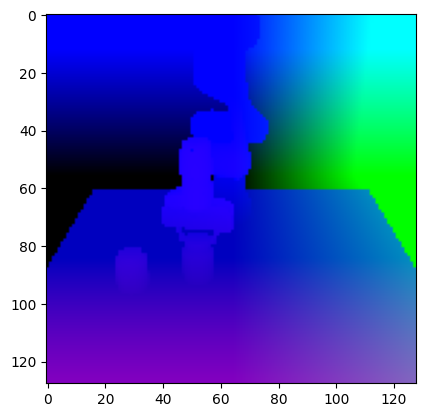

torch.Size([1, 1, 1, 128, 128])


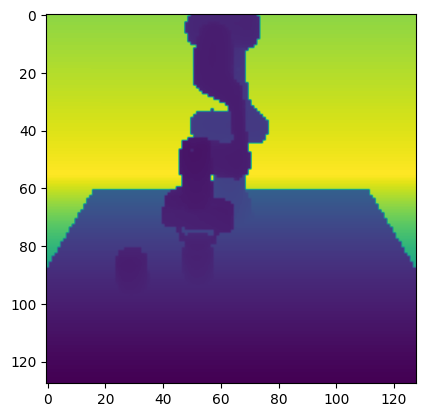

Batch:-----------------------------
_camera_names: ['front']
rgb_pcd:<class 'list'>, 1
pcd:<class 'list'>, 1
--------PerceiverIO:-------------
Input:---------------
proprio:<class 'torch.Tensor'>, torch.Size([1, 4]) tensor([[0.0000, 0.0366, 0.0365, 0.5714]], device='cuda:0')
voxel_grid: torch.Size([1, 10, 100, 100, 100])
lang_goal_emb:<class 'torch.Tensor'>, torch.Size([1, 1024])
lang_token_embs:<class 'torch.Tensor'>, torch.Size([1, 77, 512])
bounds:<class 'torch.Tensor'>, torch.Size([1, 6])
Output:---------------
q_trans: torch.Size([1, 1, 100, 100, 100])
q_rot_and_grip: torch.Size([1, 218])
q_ignore_collisions: torch.Size([1, 2]), tensor([[-0.0756,  0.0425]], device='cuda:0')
voxel_grid_feature: torch.Size([1, 128, 100, 100, 100])
lang_embedd: torch.Size([1, 77, 256])
--------_neural_renderer:-------------
Input:---------------
rgb: torch.Size([1, 3, 128, 128])
pcd: torch.Size([1, 3, 128, 128])
depth: torch.Size([1, 1, 128, 128])
language: torch.Size([1, 77, 256])
dec_fts: torch.Siz

data['xyz']: torch.Size([1, 16384, 3])
canon_xyz: torch.Size([1, 16384, 3])
xyz_voxel_space:torch.Size([1, 1, 1, 16384, 3])
voxel_feat:torch.Size([1, 128, 100, 100, 100])
point_latent: torch.Size([16384, 128])
latent before encoder: torch.Size([16384, 167])
latent after encoder: torch.Size([1, 16384, 26])
split_network_outputs: torch.Size([1, 16384, 26])
self.split_dimensions_with_offset: [3, 1, 3, 4, 3, 3, 9]
xyz_maps: torch.Size([1, 16384, 3])
opacity_maps: torch.Size([1, 16384, 1])
scale_maps: torch.Size([1, 16384, 3])
rot_maps: torch.Size([1, 16384, 4])
features_dc_maps: torch.Size([1, 16384, 3])
feature_maps: torch.Size([1, 16384, 3])
features_rest_maps: torch.Size([1, 16384, 9])
----------gs_deformation_field------------
Input----------------------------
dyna_input: torch.Size([16384, 201])
combine_inner_dims: (1, 16384)
combine_index: None
dim_size: None
batch_size: 1
Output-----------------------------
next_xyz_maps: torch.Size([1, 16384, 3])
next_rot_maps: torch.Size([1, 16384

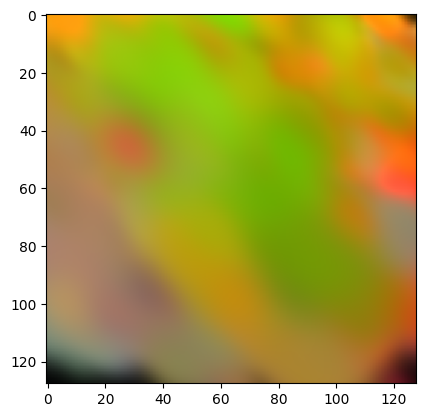

rgb_vis: (3, 128, 128)


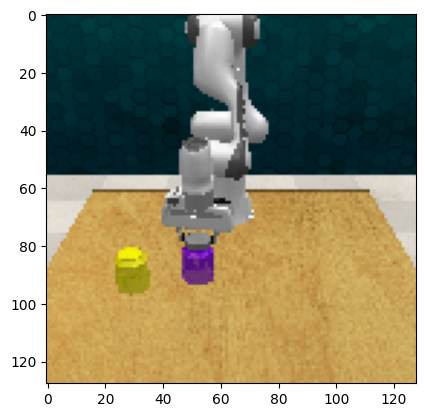

depth_vis: (1, 128, 128)


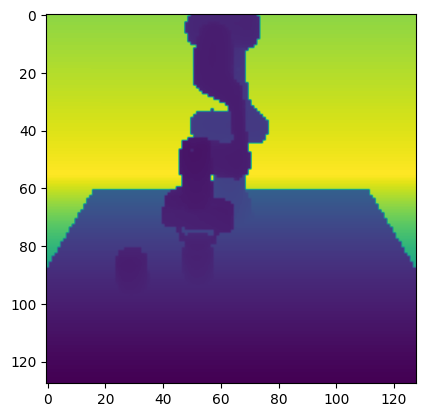

----------render--------
Input-------------------
xyz_i: torch.Size([16384, 3])
rot_i: torch.Size([16384, 4])
scale_i: torch.Size([16384, 3])
opacity_i: torch.Size([16384, 1])
bg_color: [0, 0, 0]
features_color: torch.Size([16384, 4, 3])
features_language: torch.Size([16384, 3])
Output:---------------
rendering_loss_dict: {'loss': tensor(0.1628, device='cuda:0'), 'loss_rgb': 0.15315461158752441, 'loss_embed': 0.9654613733291626, 'loss_dyna': 0.1254270374774933, 'loss_reg': 0.0, 'l1': 0.15315461158752441, 'psnr': 8.148699760437012}
total L: 28.4266 | L_BC: 28.425 x 1.000 | L_trans: 14.200 x 1.000 | L_rot: 12.798 x 1.000 | L_grip: 0.792 x 1.000 | L_col: 0.636 x 1.000 | L_rgb: 0.153 x 0.010 | L_embed: 0.965 x 0.0001 | L_dyna: 0.125 x 0.0000 | L_reg: 0.000 x 0.0000 | psnr: 8.149


data['xyz']: torch.Size([1, 16384, 3])
canon_xyz: torch.Size([1, 16384, 3])
xyz_voxel_space:torch.Size([1, 1, 1, 16384, 3])
voxel_feat:torch.Size([1, 128, 100, 100, 100])
point_latent: torch.Size([16384, 128])
latent before encoder: torch.Size([16384, 167])
latent after encoder: torch.Size([1, 16384, 26])
split_network_outputs: torch.Size([1, 16384, 26])
self.split_dimensions_with_offset: [3, 1, 3, 4, 3, 3, 9]
xyz_maps: torch.Size([1, 16384, 3])
opacity_maps: torch.Size([1, 16384, 1])
scale_maps: torch.Size([1, 16384, 3])
rot_maps: torch.Size([1, 16384, 4])
features_dc_maps: torch.Size([1, 16384, 3])
feature_maps: torch.Size([1, 16384, 3])
features_rest_maps: torch.Size([1, 16384, 9])
----------gs_deformation_field------------
Input----------------------------
dyna_input: torch.Size([16384, 201])
combine_inner_dims: (1, 16384)
combine_index: None
dim_size: None
batch_size: 1
Output-----------------------------
next_xyz_maps: torch.Size([1, 16384, 3])
next_rot_maps: torch.Size([1, 16384

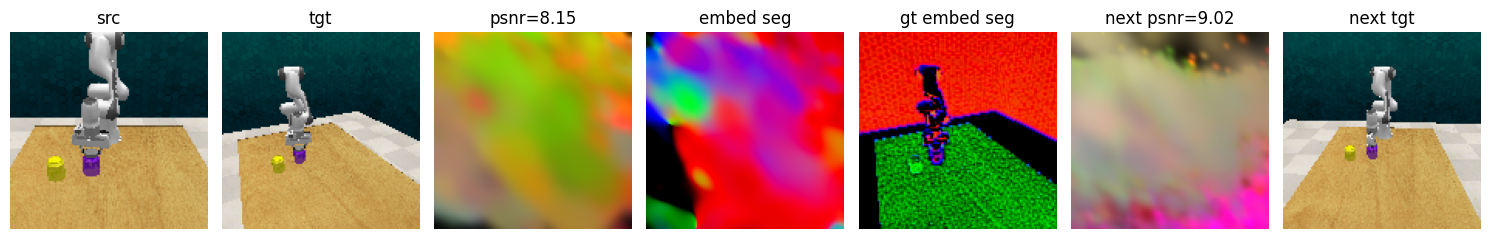

In [15]:

agent = create_agent(cfg)


train_runner = OfflineTrainRunner(
    agent=agent,
    wrapped_replay_buffer=wrapped_replay,
    train_device=rank,
    stat_accumulator=stat_accum,
    iterations=cfg.framework.training_iterations,
    logdir=logdir,
    logging_level=cfg.framework.logging_level,
    log_freq=cfg.framework.log_freq,
    weightsdir=weightsdir,
    num_weights_to_keep=cfg.framework.num_weights_to_keep,
    save_freq=cfg.framework.save_freq,
    tensorboard_logging=cfg.framework.tensorboard_logging,
    csv_logging=cfg.framework.csv_logging,
    load_existing_weights=cfg.framework.load_existing_weights,
    rank=rank,
    world_size=world_size,
    cfg=cfg,
    fabric=fabric)
cprint('Starting training!!', 'green')
train_runner.start()

nerf_next_multi_view_camera
[['data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/0.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/1.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/2.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/3.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/4.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/5.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/6.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/7.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/8.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/9.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/10.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/11.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/12.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/13.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/14.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/15.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/16.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/17.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/18.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/19.png'
  'data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/70/depths/20.png']]

In [ ]:
data = torch.rand([1, 16384, 26])
split_dimensions_with_offset = [3, 1, 3, 4, 3, 3, 9]
data = data.split(split_dimensions_with_offset, dim=-1)
for d in data:
    print(d)

tensor([[[0.1520, 0.5241, 0.4831],
         [0.1972, 0.5465, 0.9989],
         [0.5341, 0.2975, 0.7263],
         ...,
         [0.9258, 0.3954, 0.7589],
         [0.9947, 0.7745, 0.7456],
         [0.7382, 0.8440, 0.2287]]])
tensor([[[0.9038],
         [0.6809],
         [0.8705],
         ...,
         [0.0019],
         [0.4669],
         [0.3143]]])
tensor([[[0.7973, 0.5654, 0.4047],
         [0.3202, 0.4688, 0.0719],
         [0.6833, 0.8078, 0.8140],
         ...,
         [0.0027, 0.8180, 0.3547],
         [0.1490, 0.3231, 0.2540],
         [0.5515, 0.4082, 0.9793]]])
tensor([[[0.9219, 0.9973, 0.6763, 0.7647],
         [0.2071, 0.5360, 0.1560, 0.2831],
         [0.7377, 0.2261, 0.8827, 0.2364],
         ...,
         [0.0672, 0.8279, 0.7446, 0.8541],
         [0.1203, 0.1034, 0.5057, 0.8493],
         [0.0123, 0.6959, 0.4162, 0.7109]]])
tensor([[[0.4372, 0.7122, 0.7299],
         [0.1701, 0.4855, 0.1116],
         [0.8135, 0.0626, 0.1007],
         ...,
         [0.3859, 0.6770,